In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [184]:
matplotlib.rcParams.update({'font.size': 15})

In [190]:
%matplotlib notebook

In [186]:
sns.set_style('whitegrid')

## Load Data

### AM clustering data

In [90]:
# read in Am codes
codes = pd.read_excel('../data/am_3.xlsx', usecols=[2]).values

In [249]:
np.unique(codes.squeeze()).size

1076

In [105]:
# codes.squeeze()[500:]

First half (from Looker)  
[Looker explore](https://attune.looker.com/explore/Attune_Production/quotes_v4?qid=EFibNEtLVsQfrRNpepdmTG&toggle=fil)

In [116]:
amdf_1 = pd.read_csv('../data/am_3_first.csv',
                   header=0, 
    names=['activation_week', 'quote_week', 'producer_code', 'n_quotes'], 
    parse_dates=[0, 1])

In [117]:
amdf_1.count()

activation_week    3371
quote_week         3371
producer_code      3371
n_quotes           3371
dtype: int64

Second half

In [106]:
amdf_2 = pd.read_csv('../data/am_3_second.csv',
                   header=0, 
    names=['activation_week', 'quote_week', 'producer_code', 'n_quotes'], 
    parse_dates=[0, 1])

In [115]:
amdf_2.tail()

activation_week quote_week producer_code  n_quotes
3199             NaT 2018-07-30  SIAAAKS00002         1
3200             NaT 2018-09-24  SIAAAKS00002         1
3201             NaT 2019-01-14   TRIEST00001         1
3202             NaT 2019-05-20     FLIMSBLA1         1
3203             NaT 2019-10-28     FLIMSBLA1         1

In [118]:
amdf = pd.concat([amdf_1, amdf_2])

In [120]:
amdf

activation_week quote_week producer_code  n_quotes
0         2018-05-28 2018-05-21      JJC00001         4
1         2018-05-28 2018-05-28      JJC00001        13
2         2018-05-28 2018-06-04      JJC00001        14
3         2018-05-28 2018-06-11      JJC00001         1
4         2018-05-28 2018-06-18      JJC00001        10
...              ...        ...           ...       ...
3199             NaT 2018-07-30  SIAAAKS00002         1
3200             NaT 2018-09-24  SIAAAKS00002         1
3201             NaT 2019-01-14   TRIEST00001         1
3202             NaT 2019-05-20     FLIMSBLA1         1
3203             NaT 2019-10-28     FLIMSBLA1         1

[6575 rows x 4 columns]

Obtained from Looker explore

In [8]:
df = pd.read_csv(
    '../scripts/broker_activity_clustering/data/quotes_producer_week_2020.csv', 
    header=0, 
    names=['activation_week', 'quote_week', 'producer_code', 'n_quotes'], 
    parse_dates=[0, 1])

## Total Quotes

In [121]:
df = amdf.copy()

Get first 3 months of each producer's data

In [124]:
import datetime
def timedelta2days(timedelta: datetime.timedelta, tolerance=0) -> int:
        '''Convert time delta to days by rounding total seconds of duration'''
        return round(timedelta.total_seconds()/86400, tolerance)

In [131]:
df['date_diff'] = (
    df.quote_week - df.activation_week).map(lambda x: timedelta2days(x, tolerance=0))

In [134]:
three_month_filter = (df.date_diff>=0) & (df.date_diff<=90)
df = df[three_month_filter]

In [135]:
df.head()
print(f"{df.producer_code.nunique()} unique producers quoting over \
{df.quote_week.nunique()} weeks, {df.quote_week.min().date()} to {df.quote_week.max().date()}")

activation_week quote_week producer_code  n_quotes  date_diff
1      2018-05-28 2018-05-28      JJC00001        13        0.0
2      2018-05-28 2018-06-04      JJC00001        14        7.0
3      2018-05-28 2018-06-11      JJC00001         1       14.0
4      2018-05-28 2018-06-18      JJC00001        10       21.0
5      2018-05-28 2018-06-25      JJC00001         6       28.0

894 unique producers quoting over 131 weeks, 2016-12-05 to 2020-11-02


In [229]:
df.groupby('producer_code')['quote_week'].nunique().value_counts()

1     274
2     168
3     129
4     105
5      73
6      46
7      33
9      14
8      14
10     12
13     11
12      8
11      7
Name: quote_week, dtype: int64

In [232]:
df.groupby('producer_code')['quote_week'].agg(lambda x: (x.max()-x.min())).value_counts()

0 days     274
84 days     98
70 days     79
77 days     76
56 days     66
63 days     54
49 days     48
42 days     37
28 days     37
35 days     36
14 days     33
7 days      29
21 days     27
Name: quote_week, dtype: int64

In [11]:
def get_hist(data_series, nbins=50, logscale=False):
    '''Given a pandas Series of continuous data (like quote premiums),
    return histogram data with equally spaced bins given by step.
    
    Returns
    -------
    list(array):[bins(right edges), histogram counts]
    '''
    data = np.log10(data_series) if logscale else data_series
    data_min = data.min() 
    data_max = data.max()
    if data_min<0:
        hist_min = data_min-.01*data_min
    else:
        hist_min = 0
    result = np.histogram(data.values, bins=np.linspace(hist_min,data_max,nbins))
    return {'bins':result[1][1:],'counts':result[0]}

#histogram
def plot_hist(hist_data, ax, xlabel='xaxis', ylabel='yaxis',title='title', cumulative=False
              , max_scale=False, style='.',line_label=None):
    x = hist_data['bins']
    y = hist_data['counts']
    if cumulative:
        y = y.cumsum()
    if max_scale:
        y = y/y.max()
    if line_label:
        ax.plot(x,y,style,ms=15,label=line_label)
    else:
        ax.plot(x,y,style,ms=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
    
    return ax

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


ValueError: Maximum allowed size exceeded

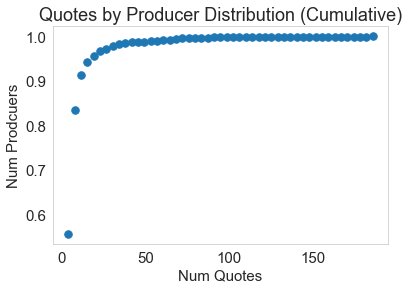

In [136]:
hist_data = get_hist(df.groupby('producer_code')['n_quotes'].sum().sort_values(ascending=False), 
                     logscale=False);

round_tol = -1;
xmin = min(0,hist_data['bins'][0])
xmax = hist_data['bins'][-1]

_, ax = plt.subplots()
plot_hist(hist_data,ax,
          xlabel='Num Quotes', ylabel="Num Prodcuers", title='Quotes by Producer Distribution (Cumulative)',
          cumulative=True, max_scale=True);

ax.xaxis.set_ticks(np.arange(xmin, xmax, round((xmax-xmin)/60, round_tol)));
ax.xaxis.set_tick_params(rotation=90);
ax.grid();

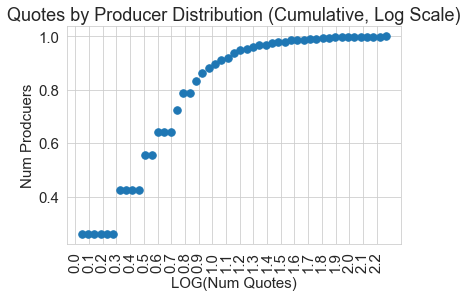

In [137]:
hist_data = get_hist(df.groupby('producer_code').sum()['n_quotes'].sort_values(ascending=False), 
                     logscale=True);

round_tol = 1;
xmin = min(0,hist_data['bins'][0])
xmax = hist_data['bins'][-1]

_, ax = plt.subplots()
plot_hist(hist_data,ax,
          xlabel='LOG(Num Quotes)', ylabel="Num Prodcuers", title='Quotes by Producer Distribution (Cumulative, Log Scale)',
          cumulative=True, max_scale=True);

ax.xaxis.set_ticks(np.arange(xmin, xmax, round((xmax-xmin)/20, round_tol)));
ax.xaxis.set_tick_params(rotation=90);
ax.grid();

On a log scale (a value of 1.0 on the x-axis is 10 quotes, 2.0 is 100,etc), we see that 
40% of producers have <=10 quotes (0.2/week average) and 75% have <= 25 (0.5/week average)

## Activation vs Quote Dates

In [138]:
qva = df.groupby('producer_code').apply(lambda x: x['quote_week'].min() - x['activation_week'].min()).value_counts()

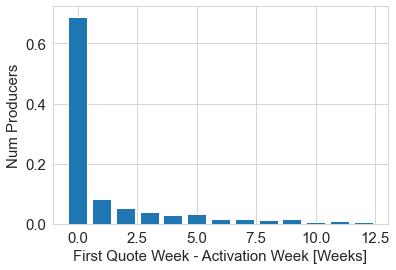

In [139]:
_, ax = plt.subplots()

x = qva.index.days/7
y  = qva.values/(qva.values.sum())

ax.bar(x,y);
ax.set_xlabel('First Quote Week - Activation Week [Weeks]');
ax.set_ylabel('Num Producers');

Half of all producers have the first quote <= 3 weeks before activation.

## Sample timeseries visualization

In [140]:
tsdf = df.drop('activation_week', axis=1).pivot(
    index='producer_code', columns='quote_week', values='n_quotes').fillna(0).copy()

In [141]:
tsdf.head(2)

quote_week     2016-12-05  2016-12-12  2016-12-19  2016-12-26  2017-01-02  \
producer_code                                                               
3BRINS00001           0.0         0.0         0.0         0.0         0.0   
618INC00001           0.0         0.0         0.0         0.0         0.0   

quote_week     2017-01-09  2017-01-16  2017-01-23  2017-01-30  2017-02-06  \
producer_code                                                               
3BRINS00001           0.0         0.0         0.0         0.0         0.0   
618INC00001           0.0         0.0         0.0         0.0         0.0   

quote_week     ...  2020-08-31  2020-09-07  2020-09-14  2020-09-21  \
producer_code  ...                                                   
3BRINS00001    ...         1.0         0.0         0.0         0.0   
618INC00001    ...         0.0         0.0         0.0         0.0   

quote_week     2020-09-28  2020-10-05  2020-10-12  2020-10-19  2020-10-26  \
producer_code                                                               
3BRINS00001           0.0         0.0         0.0         0.0         0.0   
618INC00001           0.0         0.0         0.0         0.0         0.0   

quote_week     2020-11-02  
producer_code              
3BRINS00001           0.0  
618INC00001           0.0  

[2 rows x 131 columns]

<IPython.core.display.Javascript object>


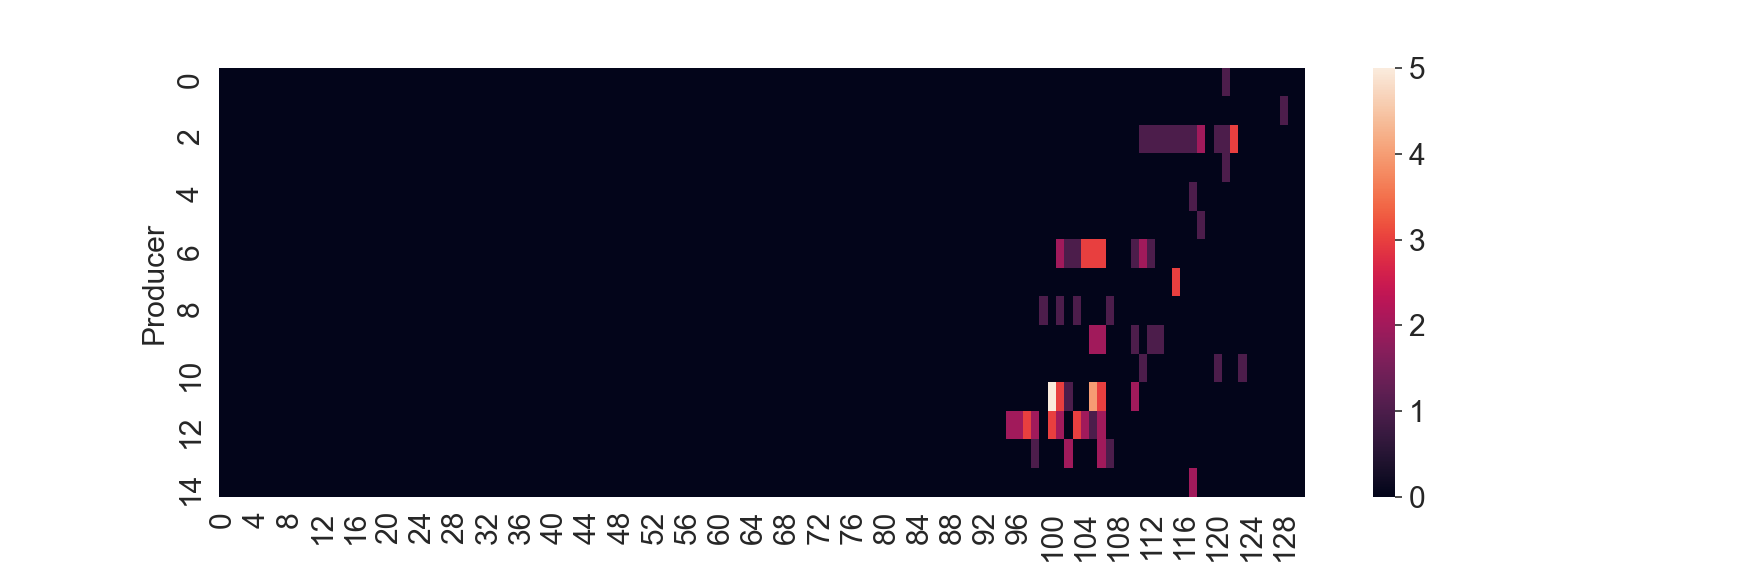

In [224]:
_, ax = plt.subplots(figsize=(14,4))
ax = sns.heatmap(tsdf.sample(15).values)

ax.set_xlabel('Week');
ax.set_ylabel('Producer');

<IPython.core.display.Javascript object>


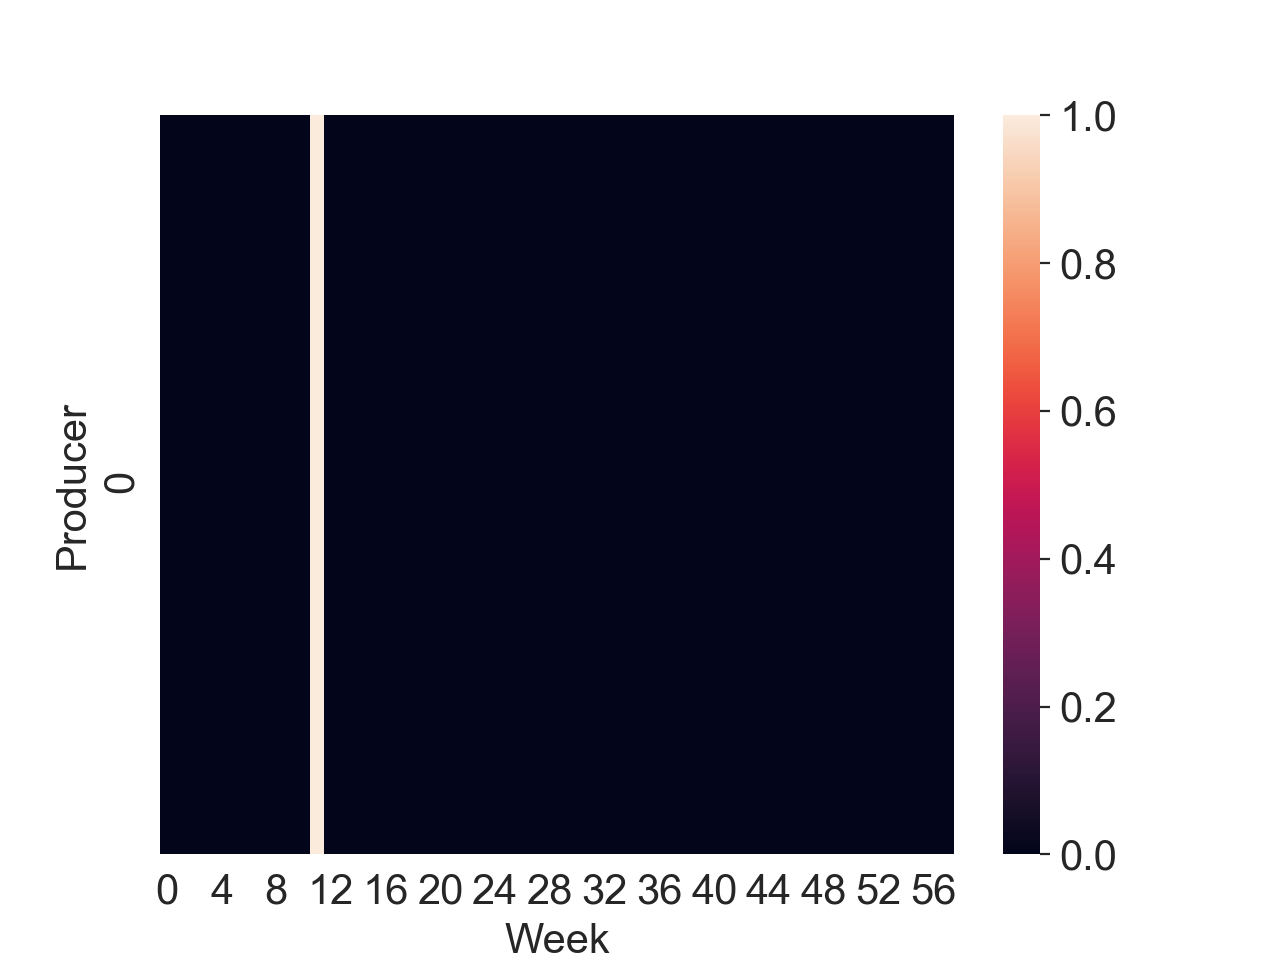

In [386]:
_, ax = plt.subplots(
#     figsize=(14,4)
)
ax = sns.heatmap(tsdf[tsdf.index=='ABRI00001'].values)

ax.set_xlabel('Week');
ax.set_ylabel('Producer');

## Linear Regression Feature

- For each producer timeseries, normalize to max nquotes/week and compute slope

In [563]:
from scipy import stats

In [568]:
def lr_feature_extract(producer_code, ts):
    '''This will be applied to each row (timeseries of a single producer) of tsdf'''
    
    #Trim each producer time series to start at first week of quote or activation
    start_week = min(a_week[producer_code], q_week[producer_code])
    trimmed = ts.loc[start_week:]
    nquotes = trimmed.sum()
    trimmed = trimmed/nquotes

    slope, intercept, r_value, p_value, std_err = stats.linregress(range(trimmed.size),trimmed.values)
    
    features = {'producer_code': producer_code, 'slope': slope, 'intercept': intercept,
               "r-squared": r_value**2, 'p_value': p_value, "std_err": std_err}
    
    return features

In [572]:
lr_feature_list = []
for pc, ts in tsdf.iterrows():
    lr_feature_list.append(lr_feature_extract(pc,ts))

In [573]:
lrdf = pd.DataFrame(lr_feature_list)
lrdf.head()

producer_code     slope  intercept  r-squared   p_value   std_err
0       A0B7635 -0.001894   0.060606   0.035417  0.294265  0.001775
1   AANAKA00001 -0.001767   0.058839   0.163840  0.012955  0.000675
2  ABRAHAM00001 -0.000025   0.024884   0.000338  0.909113  0.000215
3     ABRI00001 -0.001613   0.060797   0.032873  0.193849  0.001225
4      ACL00001  0.000202   0.011887   0.032925  0.176753  0.000148

<IPython.core.display.Javascript object>


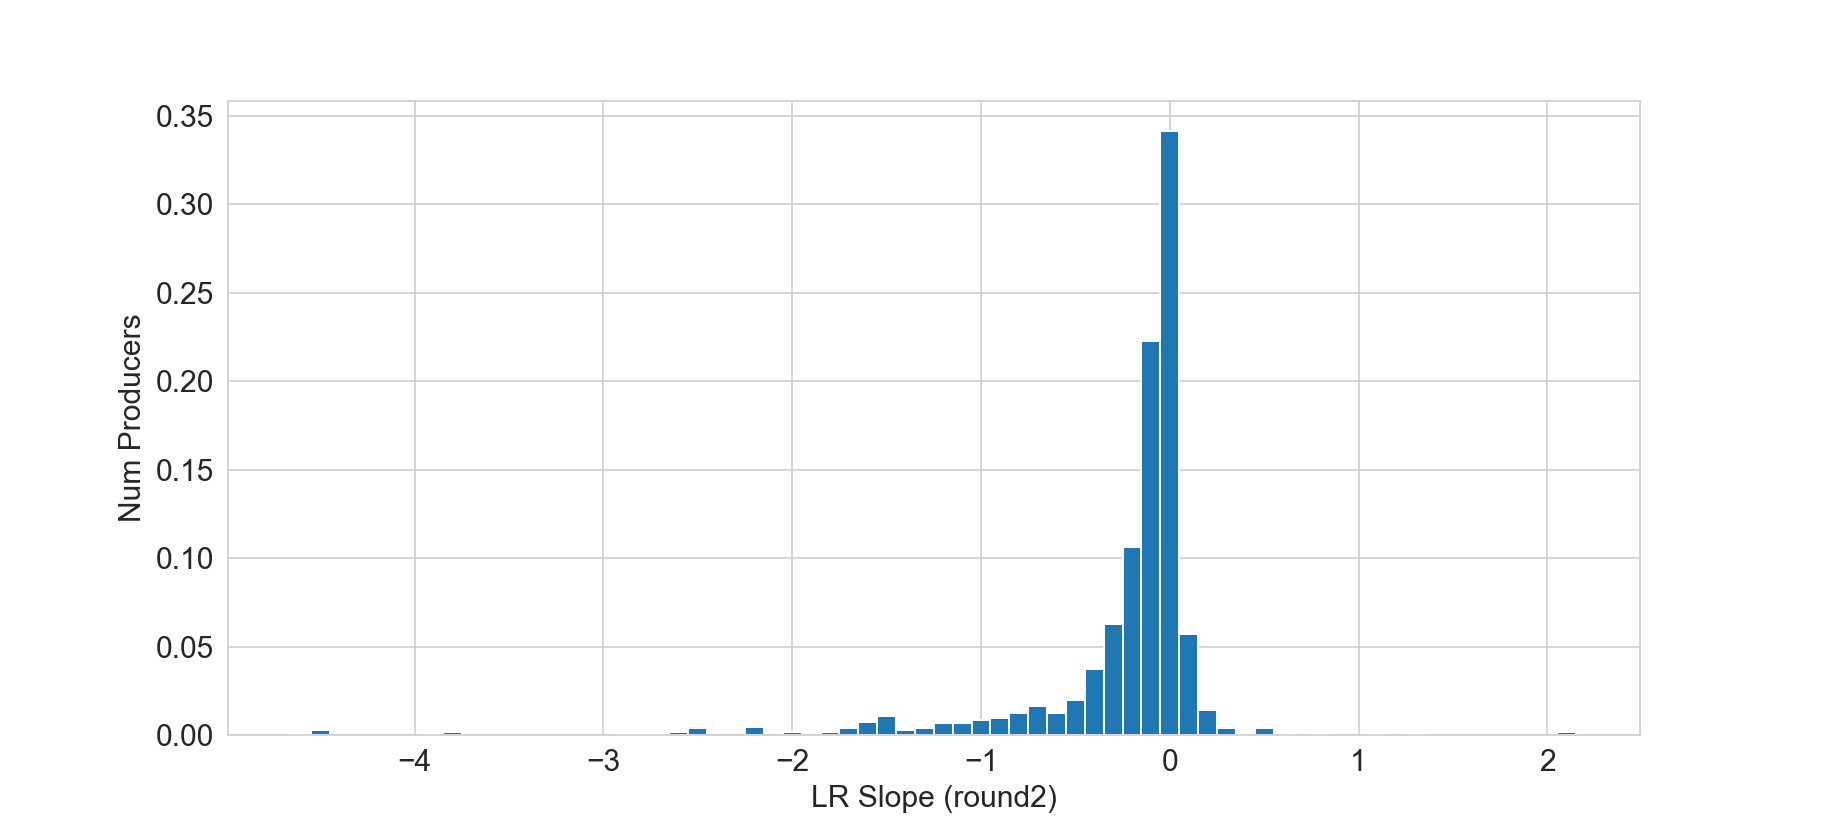

In [656]:
_, ax = plt.subplots()

dat = round(100*lrdf.slope, 1).value_counts()
x = dat.index.values
y  = dat.values/(dat.values.sum())

ax.bar(x,y, width=.1);
ax.set_xlabel('LR Slope (round2)');
ax.set_ylabel('Num Producers');

In [667]:
dat[dat.index<-1].sum() / dat.sum()
dat[(dat.index>=-1) & (dat.index<0)].sum() / dat.sum()
dat[dat.index>=0].sum() / dat.sum()

0.0655893536121673

0.5076045627376425

0.4268060836501901

In [728]:
def slope_bucket(slope, churn_thresh=-1, consistent_thresh=-.1):
    scaled = round(100*slope, 1)
    if scaled <= churn_thresh:
        return 'churned'
    elif scaled > churn_thresh and scaled < consistent_thresh:
        return 'loss'
    return 'consistent'

In [729]:
def add_slope_bucket_feature(churn_thresh, consistent_thresh, lrdf, fdf):
    lrdf['eng_level'] = lrdf.slope.map(lambda x: slope_bucket(x, churn_thresh, consistent_thresh))
    if 'eng_level' in fdf.columns:
        fdf.drop('eng_level', axis=1, inplace=True)
    return fdf.merge(lrdf[['producer_code','eng_level']], on='producer_code')

In [732]:
fdf = add_slope_bucket_feature(-1, -.1, lrdf, fdf)
fdf.head()

producer_code  fraction_weeks_active  fraction_active_period    ip_min  \
0       A0B7635               0.121212                0.969697  0.000000   
1   AANAKA00001               0.270270                0.675676  0.027027   
2  ABRAHAM00001               0.951220                0.975610  0.000000   
3     ABRI00001               0.018868                0.000000  0.867925   
4      ACL00001               0.666667                0.982456  0.000000   

     ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  ...  \
0  0.787879  0.242424  0.317821        0.060606  0.166667  0.500000  ...   
1  0.270270  0.094595  0.071762        0.000000  0.090909  0.181818  ...   
2  0.048780  0.025016  0.006736        0.000000  0.008333  0.083333  ...   
3  0.867925  0.867925  0.000000        0.000000  1.000000  1.000000  ...   
4  0.087719  0.025854  0.017422        0.017544  0.016667  0.083333  ...   

   q2_quotes  q3_quotes  q4_quotes  q5_quotes      tsne1      tsne2  k4  k5  \
0   0.000000   0.000000   0.000000   0.333333   0.201032  38.740540   2   2   
1   0.363636   0.090909   0.181818   0.000000   9.912664   6.801758   0   0   
2   0.183333   0.275000   0.200000   0.175000 -35.615322 -31.741970   3   3   
3   0.000000   0.000000   0.000000   0.000000  70.285477 -11.327139   1   4   
4   0.200000   0.183333   0.233333   0.266667 -23.123886 -25.152096   3   3   

   k3   eng_level  
0   2        loss  
1   0        loss  
2   0  consistent  
3   1        loss  
4   0  consistent  

[5 rows x 23 columns]

## Feature extraction

- weeks active / weeks total
- active range / days total
- max/min/mean/std inactivity periods in days / days total
- max/min/mean/std quotes per active week / total quotes
- fraction through cycle when activation occurs
- fraction quotes per quintile in cycle

In [145]:
a_week = df.groupby('producer_code')['activation_week'].agg('first') 
q_week = df.groupby('producer_code').apply(lambda x: x['quote_week'].min())

In [146]:
def feature_extract(producer_code, ts):
    '''This will be applied to each row (timeseries of a single producer) of tsdf'''
#     print(producer_code)
    #Trim each producer time series to start at first week of quote or activation
    start_week = min(a_week[producer_code], q_week[producer_code])
    trimmed = ts.loc[start_week:]
    
    nweeks_active = trimmed[trimmed>0].size
    weeks_active_index = trimmed[trimmed>0].index
    nweeks = trimmed.size
    ndays = nweeks*7.0
    nquotes = trimmed.sum()
    
    fraction_weeks_active = nweeks_active / nweeks
    
    if fraction_weeks_active==0:
        return {'producer_code': producer_code, 'fraction_weeks_active': fraction_weeks_active, 
                'fraction_active_period': 0,
                'ip_min': 1, 'ip_max': 1, 
                'ip_mean': 1, 'ip_std': 1,
                'when_activated': 0
#                 , 'nweeks': nweeks
               }
    
    #get number of days between quotes and days from last quote until end
    inactive_periods = np.append([interval.days for interval in (weeks_active_index[1:] - weeks_active_index[:-1])],
                                 (trimmed.index[-1] - weeks_active_index[-1]).days)
    
    #days from first to last active
    active_period = (weeks_active_index[-1] - weeks_active_index[0]).days
    
#     #churn event if more than a week stop after last active
#     churn = False
#     if inactive_periods[-1]>=10:
#         churn = True
    
    # min/max/mean/std quotes per active week
    nquotes_stats = trimmed[trimmed>0].agg(['min','max','mean','std']).fillna(0).values / nquotes
    
    #fraction through cycle where activation occurs
    try:
        when_activated = trimmed.index.get_loc(a_week[producer_code]) / nweeks
    except:
        when_activated =0
    
    #fraction of quotes per quintile
    bounds = np.linspace(0, nweeks, 6, dtype=int)
    quintile_fractions = [trimmed[bounds[i]:bounds[i+1]].sum()/nquotes for i in range(bounds.size-1)]
    
    
    features = {'producer_code': producer_code, 'fraction_weeks_active': fraction_weeks_active, 
                'fraction_active_period': active_period / ndays,
                'ip_min': inactive_periods.min() / ndays, 'ip_max': inactive_periods.max() / ndays, 
                'ip_mean': inactive_periods.mean() / ndays, 'ip_std': inactive_periods.std() / ndays,
                'when_activated': when_activated
#                 , 'nweeks': nweeks
               }
    
    features.update(dict(zip(['nq_min', 'nq_max', 'nq_mean', 'nq_std'], nquotes_stats)))
    features.update(dict(zip(['q1_quotes', 'q2_quotes', 'q3_quotes', 'q4_quotes', 'q5_quotes'], 
                             quintile_fractions)))
    
    return features

### Group timeseries into first and second half of the year

In [105]:
#num producers that activated before May
df[df.activation_week<=pd.to_datetime('2019-05-01')].producer_code.nunique()

340

In [113]:
first_half_tsdf = tsdf[tsdf.index.isin(df[df.activation_week<=pd.to_datetime('2019-05-01')]\
                                       .producer_code.unique())].copy()

In [116]:
first_half_tsdf.index.size

340

In [127]:
ts1 = first_half_tsdf.iloc[:,:29].copy()
ts2 = first_half_tsdf.iloc[:,29:].copy()

In [151]:
yp_fdf = []
for tsdf in (ts1, ts2):
    feature_list = []
    for pc, ts in tsdf.iterrows():
        feature_list.append(feature_extract(pc,ts))
    yp_fdf.append(pd.DataFrame(feature_list))

### Feature extraction for full timeseries

In [147]:
feature_list = []
for pc, ts in tsdf.iterrows():
    feature_list.append(feature_extract(pc,ts))

In [148]:
fdf = pd.DataFrame(feature_list)

In [149]:
fdf.count()
fdf.head(2)

producer_code             894
fraction_weeks_active     894
fraction_active_period    894
ip_min                    894
ip_max                    894
ip_mean                   894
ip_std                    894
when_activated            894
nq_min                    894
nq_max                    894
nq_mean                   894
nq_std                    894
q1_quotes                 894
q2_quotes                 894
q3_quotes                 894
q4_quotes                 894
q5_quotes                 894
dtype: int64

producer_code  fraction_weeks_active  fraction_active_period    ip_min  \
0   3BRINS00001               0.100000                0.000000  0.900000   
1   618INC00001               0.157895                0.315789  0.105263   

     ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max   nq_mean  \
0  0.900000  0.900000  0.000000             0.0  1.000000  1.000000  1.000000   
1  0.631579  0.315789  0.227394             0.0  0.333333  0.333333  0.333333   

   nq_std  q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  
0     0.0   1.000000   0.000000        0.0        0.0        0.0  
1     0.0   0.333333   0.666667        0.0        0.0        0.0

In [320]:
# fdf.merge(df[['producer_code','year_part']].drop_duplicates(), how='left', on='producer_code').head()

In [150]:
fdf.describe()

fraction_weeks_active  fraction_active_period      ip_min      ip_max  \
count             894.000000              894.000000  894.000000  894.000000   
mean                0.186606                0.292191    0.314306    0.624299   
std                 0.158654                0.270923    0.350886    0.234684   
min                 0.012821                0.000000    0.000000    0.000000   
25%                 0.076923                0.000000    0.050000    0.458333   
50%                 0.133333                0.263158    0.112698    0.612903   
75%                 0.250000                0.500000    0.606522    0.833333   
max                 1.000000                0.923077    1.087719    1.469231   

          ip_mean      ip_std  when_activated      nq_min      nq_max  \
count  894.000000  894.000000           894.0  894.000000  894.000000   
mean     0.426354    0.128738             0.0    0.481850    0.574971   
std      0.291264    0.119175             0.0    0.366369    0.307263   
min      0.000000    0.000000             0.0    0.011236    0.136364   
25%      0.192308    0.000000             0.0    0.166667    0.333333   
50%      0.317063    0.118134             0.0    0.333333    0.500000   
75%      0.606522    0.213901             0.0    1.000000    1.000000   
max      1.087719    0.638698             0.0    1.000000    1.000000   

          nq_mean      nq_std   q1_quotes   q2_quotes   q3_quotes   q4_quotes  \
count  894.000000  894.000000  894.000000  894.000000  894.000000  894.000000   
mean     0.515532    0.048896    0.531203    0.204682    0.130902    0.087987   
std      0.342666    0.074729    0.363792    0.269336    0.222165    0.199756   
min      0.076923    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.250000    0.000000    0.250000    0.000000    0.000000    0.000000   
50%      0.333333    0.000000    0.500000    0.000000    0.000000    0.000000   
75%      1.000000    0.078652    1.000000    0.333333    0.200000    0.000000   
max      1.000000    0.471405    1.000000    1.000000    1.000000    1.000000   

        q5_quotes  
count  894.000000  
mean     0.045226  
std      0.153523  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

## Feature Selection

In [83]:
fdf.head(2)

producer_code  fraction_weeks_active  fraction_active_period    ip_min  \
0   3BRINS00001               0.111111                0.000000  0.888889   
1   618INC00001               0.128205                0.692308  0.051282   

     ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  ...  \
0  0.888889  0.888889  0.000000        0.000000  1.000000  1.000000  ...   
1  0.333333  0.194872  0.105845        0.538462  0.142857  0.428571  ...   

   q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  k4  k5     tsne1  \
0   1.000000   0.000000   0.000000   0.000000        0.0   2   4 -4.807352   
1   0.428571   0.142857   0.142857   0.285714        0.0   1   0 -7.342596   

       tsne2  corr_k  
0  85.261436      10  
1  23.784348      30  

[2 rows x 22 columns]

In [264]:
pearsondf = fdf[[c for c in fdf.columns if c not in [
    'producer_code','k5','k3','tsne1', 'tsne2','when_activated']]].corr()

In [263]:
midf = fdf[[c for c in fdf.columns if c not in [
    'producer_code','k5','k3','tsne1', 'tsne2','when_activated']]].corr(
    method=lambda x,y: mutual_info_regression(x.reshape(-1, 1), y))

In [301]:
midf[(midf>=0.9)]

fraction_weeks_active  fraction_active_period  \
fraction_weeks_active                1.000000                     NaN   
fraction_active_period                    NaN                1.000000   
ip_min                               1.303007                1.417966   
ip_max                               1.110917                1.188625   
ip_mean                              1.700105                     NaN   
ip_std                                    NaN                1.143742   
nq_min                                    NaN                     NaN   
nq_max                                    NaN                     NaN   
nq_mean                                   NaN                     NaN   
nq_std                                    NaN                     NaN   
q1_quotes                                 NaN                     NaN   
q2_quotes                                 NaN                     NaN   
q3_quotes                                 NaN                     NaN   
q4_quotes                                 NaN                     NaN   
q5_quotes                                 NaN                     NaN   
k4                                        NaN                     NaN   

                          ip_min    ip_max   ip_mean    ip_std    nq_min  \
fraction_weeks_active   1.303007  1.110917  1.700105       NaN       NaN   
fraction_active_period  1.417966  1.188625       NaN  1.143742       NaN   
ip_min                  1.000000  1.807906  2.136931       NaN       NaN   
ip_max                  1.807906  1.000000  1.564996  1.169283       NaN   
ip_mean                 2.136931  1.564996  1.000000       NaN  1.127231   
ip_std                       NaN  1.169283       NaN  1.000000       NaN   
nq_min                       NaN       NaN  1.127231       NaN  1.000000   
nq_max                       NaN       NaN  1.056335       NaN  1.625352   
nq_mean                      NaN       NaN  1.588663       NaN  1.363795   
nq_std                       NaN       NaN       NaN       NaN  1.086110   
q1_quotes                    NaN       NaN       NaN       NaN  1.104998   
q2_quotes                    NaN       NaN       NaN       NaN  0.915695   
q3_quotes                    NaN       NaN       NaN       NaN       NaN   
q4_quotes                    NaN       NaN       NaN       NaN       NaN   
q5_quotes                    NaN       NaN       NaN       NaN       NaN   
k4                           NaN       NaN       NaN       NaN       NaN   

                          nq_max   nq_mean    nq_std  q1_quotes  q2_quotes  \
fraction_weeks_active        NaN       NaN       NaN        NaN        NaN   
fraction_active_period       NaN       NaN       NaN        NaN        NaN   
ip_min                       NaN       NaN       NaN        NaN        NaN   
ip_max                       NaN       NaN       NaN        NaN        NaN   
ip_mean                 1.056335  1.588663       NaN        NaN        NaN   
ip_std                       NaN       NaN       NaN        NaN        NaN   
nq_min                  1.625352  1.363795  1.086110   1.104998   0.915695   
nq_max                  1.000000  1.273188  1.231245   0.924159        NaN   
nq_mean                 1.273188  1.000000       NaN        NaN        NaN   
nq_std                  1.231245       NaN  1.000000        NaN        NaN   
q1_quotes               0.924159       NaN       NaN   1.000000        NaN   
q2_quotes                    NaN       NaN       NaN        NaN   1.000000   
q3_quotes                    NaN       NaN       NaN        NaN        NaN   
q4_quotes                    NaN       NaN       NaN        NaN        NaN   
q5_quotes                    NaN       NaN       NaN        NaN        NaN   
k4                           NaN       NaN       NaN        NaN        NaN   

                        q3_quotes  q4_quotes  q5_quotes   k4  
fraction_weeks_active         NaN        NaN        NaN  NaN  
fraction_active_period        NaN   

In [296]:
pearsondf

fraction_weeks_active  fraction_active_period  \
fraction_weeks_active                1.000000                0.771015   
fraction_active_period               0.771015                1.000000   
ip_min                              -0.495441               -0.638195   
ip_max                              -0.646858               -0.651997   
ip_mean                             -0.589330               -0.671499   
ip_std                               0.010480                0.209582   
nq_min                              -0.606667               -0.754733   
nq_max                              -0.587192               -0.738034   
nq_mean                             -0.613804               -0.760041   
nq_std                               0.208765                0.310376   
q1_quotes                           -0.391942               -0.425608   
q2_quotes                            0.064457                0.064351   
q3_quotes                            0.174975                0.204556   
q4_quotes                            0.255683                0.277619   
q5_quotes                            0.229784                0.238397   
k4                                   0.632262                0.799670   

                          ip_min    ip_max   ip_mean    ip_std    nq_min  \
fraction_weeks_active  -0.495441 -0.646858 -0.589330  0.010480 -0.606667   
fraction_active_period -0.638195 -0.651997 -0.671499  0.209582 -0.754733   
ip_min                  1.000000  0.605476  0.960654 -0.706542  0.890945   
ip_max                  0.605476  1.000000  0.733459  0.099328  0.497025   
ip_mean                 0.960654  0.733459  1.000000 -0.508342  0.875892   
ip_std                 -0.706542  0.099328 -0.508342  1.000000 -0.620028   
nq_min                  0.890945  0.497025  0.875892 -0.620028  1.000000   
nq_max                  0.874631  0.483449  0.858539 -0.610682  0.941865   
nq_mean                 0.896497  0.500025  0.883613 -0.620366  0.991539   
nq_std                 -0.377018 -0.210127 -0.347962  0.297158 -0.506741   
q1_quotes               0.499773  0.786240  0.593404  0.036876  0.317836   
q2_quotes              -0.261591 -0.144954 -0.255737  0.194625 -0.225412   
q3_quotes              -0.193248 -0.438386 -0.262488 -0.134883 -0.149530   
q4_quotes              -0.187622 -0.472106 -0.257036 -0.148607 -0.109317   
q5_quotes              -0.201571 -0.360120 -0.243198 -0.040275  0.000928   
k4                     -0.711673 -0.483307 -0.688365  0.451254 -0.867804   

                          nq_max   nq_mean    nq_std  q1_quotes  q2_quotes  \
fraction_weeks_active  -0.587192 -0.613804  0.208765  -0.391942   0.064457   
fraction_active_period -0.738034 -0.760041  0.310376  -0.425608   0.064351   
ip_min                  0.874631  0.896497 -0.377018   0.499773  -0.261591   
ip_max                  0.483449  0.500025 -0.210127   0.786240  -0.144954   
ip_mean                 0.858539  0.883613 -0.347962   0.593404  -0.255737   
ip_std                 -0.610682 -0.620366  0.297158   0.036876   0.194625   
nq_min                  0.941865  0.991539 -0.506741   0.317836  -0.225412   
nq_max                  1.000000  0.973029 -0.199215   0.320165  -0.233169   
nq_mean                 0.973029  1.000000 -0.396182   0.322186  -0.230961   
nq_std                 -0.199215 -0.396182  1.000000  -0.123906   0.067191   
q1_quotes               0.320165  0.322186 -0.123906   1.000000  -0.513942   
q2_quotes              -0.233169 -0.230961  0.067191  -0.513942   1.000000   
q3_quotes              -0.165202 -0.156691  0.024360  -0.446932  -0.147989   
q4_quotes              -0.085784 -0.099572  0.115906  -0.395646  -0.171479   
q5_quotes               0.001075 -0.001963 -0.010328  -0.306429  -0.099243   
k4                     -0.845294 -0.869692  0.388772  -0.288878   0.100486   

                        q3_quotes  q4_quotes  q5_quotes        k4  
fraction_weeks_active    0.174975   0.255683   0.229784  0.632262  
fraction_active_period   0

In [256]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

## K-means & tSNE clustering

### K-means

In [151]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import time

In [152]:
X = fdf.drop('producer_code', axis=1).values

In [34]:
# mms = MinMaxScaler()
# mms.fit(X)
# data_transformed = mms.transform(X)

In [153]:
Sum_of_squared_distances = []
K = range(2,15)

for k in K:
    time_start = time.time()
    km = KMeans(n_clusters=k, random_state=42, n_init=30, max_iter=400)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    print('kmeans {} done! Time elapsed: {} seconds'.format(k,time.time()-time_start))

kmeans 2 done! Time elapsed: 0.11667728424072266 seconds
kmeans 3 done! Time elapsed: 0.14757513999938965 seconds
kmeans 4 done! Time elapsed: 0.1399538516998291 seconds
kmeans 5 done! Time elapsed: 0.15068817138671875 seconds
kmeans 6 done! Time elapsed: 0.17963004112243652 seconds
kmeans 7 done! Time elapsed: 0.2215721607208252 seconds
kmeans 8 done! Time elapsed: 0.24251174926757812 seconds
kmeans 9 done! Time elapsed: 0.2623312473297119 seconds
kmeans 10 done! Time elapsed: 0.2658679485321045 seconds
kmeans 11 done! Time elapsed: 0.2510251998901367 seconds
kmeans 12 done! Time elapsed: 0.24641728401184082 seconds
kmeans 13 done! Time elapsed: 0.30848121643066406 seconds
kmeans 14 done! Time elapsed: 0.29621195793151855 seconds


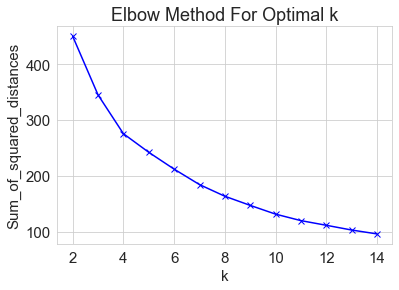

In [154]:
plt.plot(K, Sum_of_squared_distances, 'bx-');
plt.xlabel('k');
plt.ylabel('Sum_of_squared_distances');
plt.title('Elbow Method For Optimal k');
plt.show();

#### K-means on each year-part

In [155]:
yp_clusters = []
for fdf in yp_fdf:
    X = fdf.drop(['producer_code'], axis=1).fillna(0).values
    km = KMeans(n_clusters=5, random_state=0, n_init=30, max_iter=400)
    klabels = km.fit_predict(X)
    fdf['k5'] = klabels
    yp_clusters.append(fdf)

#### K-means on all data

In [174]:
for k in [3,4,5]:
    km = KMeans(n_clusters=k, random_state=0, n_init=30, max_iter=400)
    klabels = km.fit_predict(X)
    fdf['k'+str(k)] = klabels

In [175]:
fdf.head()

producer_code  fraction_weeks_active  fraction_active_period    ip_min  \
0   3BRINS00001               0.100000                0.000000  0.900000   
1   618INC00001               0.157895                0.315789  0.105263   
2     AAAI00001               0.052632                0.000000  0.368421   
3    ABIDE00001               0.466667                0.666667  0.066667   
4      ACE00001               0.156250                0.375000  0.031250   

     ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  ...  \
0  0.900000  0.900000  0.000000             0.0  1.000000  1.000000  ...   
1  0.631579  0.315789  0.227394             0.0  0.333333  0.333333  ...   
2  0.368421  0.368421  0.000000             0.0  1.000000  1.000000  ...   
3  0.266667  0.133333  0.071270             0.0  0.090909  0.272727  ...   
4  0.593750  0.193750  0.215964             0.0  0.200000  0.200000  ...   

   q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  k4  k5      tsne1  \
0   1.000000   0.000000   0.000000   0.000000        0.0   1   2   7.236337   
1   0.333333   0.666667   0.000000   0.000000        0.0   2   1   7.840956   
2   0.000000   0.000000   0.000000   1.000000        0.0   0   4  -2.369485   
3   0.272727   0.272727   0.181818   0.272727        0.0   3   0  11.151847   
4   0.600000   0.200000   0.200000   0.000000        0.0   2   1  -2.473596   

       tsne2  k3  
0 -50.780754   0  
1  28.072641   1  
2 -11.644526   2  
3   6.702907   1  
4  16.799379   1  

[5 rows x 22 columns]

### tSNE

In [157]:
from sklearn.manifold import TSNE

In [158]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, n_iter=1600, perplexity=30)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 894 samples in 0.007s...
[t-SNE] Computed neighbors for 894 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 894 / 894
[t-SNE] Mean sigma: 0.034393
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.499622
[t-SNE] KL divergence after 1600 iterations: 0.397772
t-SNE done! Time elapsed: 4.443337917327881 seconds


In [159]:
fdf['tsne1'] = tsne_results[:,0]
fdf['tsne2'] = tsne_results[:,1]

### Plot using TSNE coordinates and K-means coloring¶

<IPython.core.display.Javascript object>


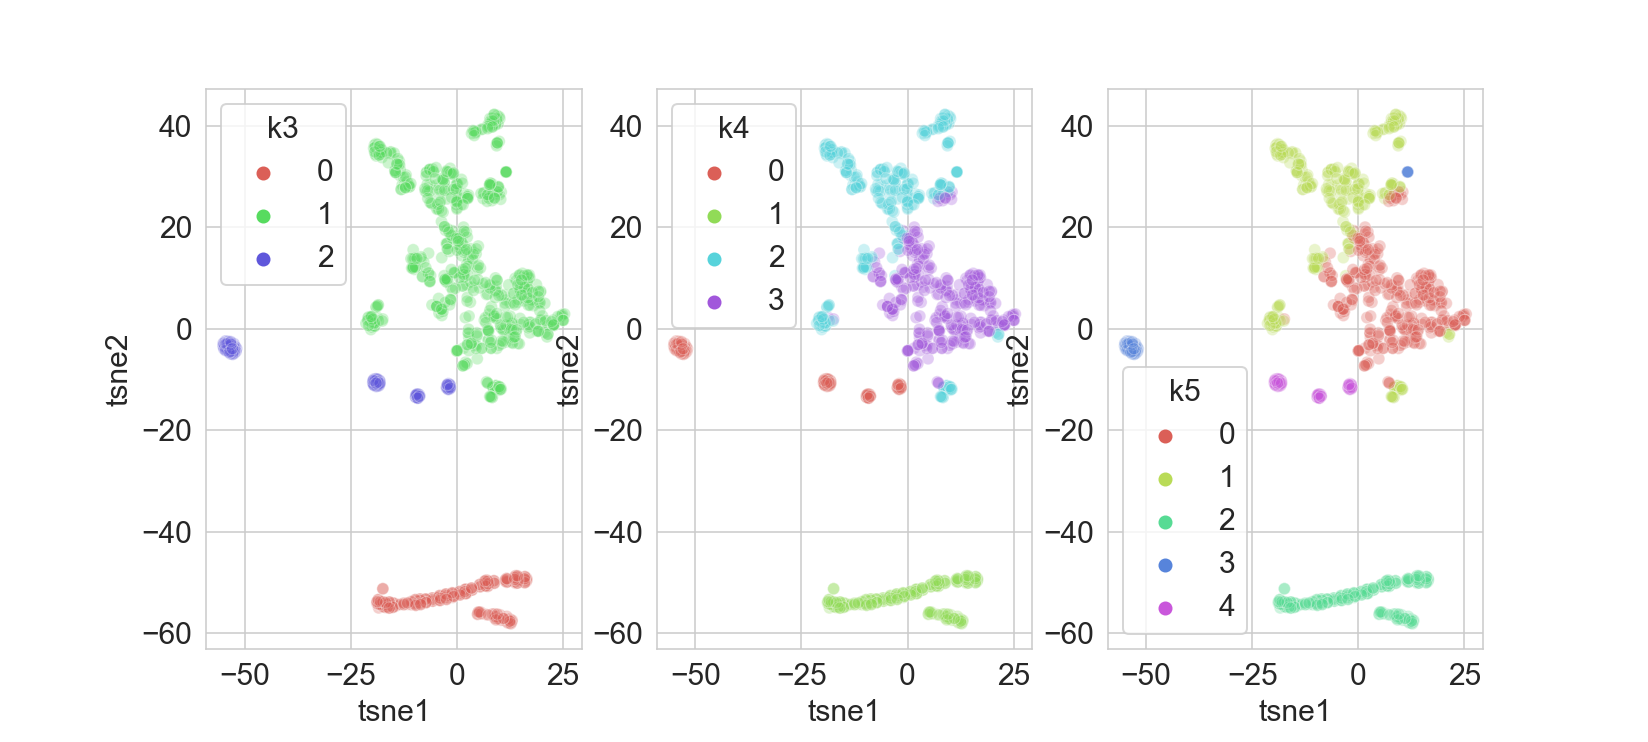

In [191]:
# plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 3, 1);
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k3",
    palette=sns.color_palette("hls", 3),
    data=fdf,
    legend="full",
    alpha=0.3, ax=ax1
)

ax2 = plt.subplot(1, 3, 2);
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k4",
    palette=sns.color_palette("hls", 4),
    data=fdf,
    legend="full",
    alpha=0.3, ax=ax2
)

ax3 = plt.subplot(1, 3, 3);
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k5",
    palette=sns.color_palette("hls", 5),
    data=fdf,
    legend="full",
    alpha=0.3, ax=ax3
)

# ax4 = plt.subplot(2, 2, 4);
# sns.scatterplot(
#     x="tsne1", y="tsne2",
#     hue="eng_level",
#     palette=sns.color_palette("hls", 3),
#     data=fdf,
#     legend="full",
#     alpha=0.3, ax=ax4
# )

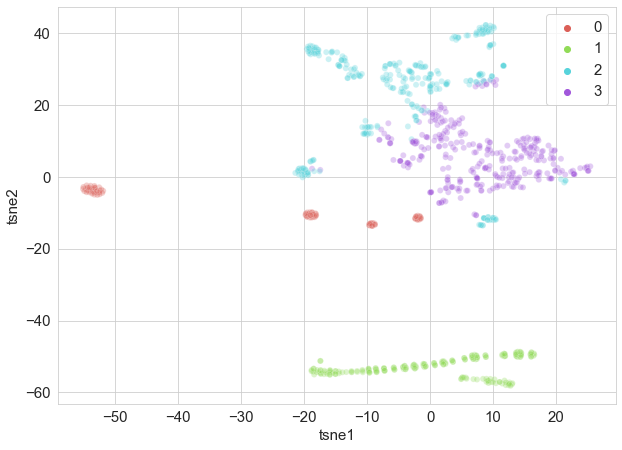

In [173]:
_,ax = plt.subplots(figsize=(10,7.3))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="k4",
    palette=sns.color_palette("hls", 4),
    data=fdf,
#     legend="full",
    alpha=0.3, ax=ax
)
ax.legend()

### Examine Clusters

#### cluster number-feature correlation

In [77]:
# 2020 data
def k_translate(cluster_num: int) -> str:
    tdict = {1: 'very_low_2020', 0: 'low_dip_2020', 3: 'active_2020',
             2: 'immediate_ca_2020', 4: 'immediate_2020'}
    tdict = {1: 20, 0: 30, 3: 40,
             2: 10, 4: 10}
    return tdict[cluster_num]

In [78]:
fdf['corr_k'] = fdf.k5.map(lambda x: k_translate(x))

In [82]:
fdf.filter(like='nq_')

nq_min    nq_max   nq_mean    nq_std
0     1.000000  1.000000  1.000000  0.000000
1     0.142857  0.428571  0.200000  0.127775
2     0.200000  0.200000  0.200000  0.000000
3     0.500000  0.500000  0.500000  0.000000
4     0.083333  0.250000  0.100000  0.052705
...        ...       ...       ...       ...
1788  1.000000  1.000000  1.000000  0.000000
1789  0.090909  0.181818  0.100000  0.028748
1790  0.062500  0.187500  0.076923  0.037447
1791  0.250000  0.500000  0.333333  0.144338
1792  0.200000  0.400000  0.333333  0.115470

[1793 rows x 4 columns]

In [318]:
fdf[[c for c in fdf.columns if c not in [
    'producer_code', 'k4', 'k5','tsne1', 'tsne2']]].corr()

fraction_weeks_active  fraction_active_period  \
fraction_weeks_active                1.000000                0.771015   
fraction_active_period               0.771015                1.000000   
ip_min                              -0.495441               -0.638195   
ip_max                              -0.646858               -0.651997   
ip_mean                             -0.589330               -0.671499   
ip_std                               0.010480                0.209582   
when_activated                            NaN                     NaN   
nq_min                              -0.606667               -0.754733   
nq_max                              -0.587192               -0.738034   
nq_mean                             -0.613804               -0.760041   
nq_std                               0.208765                0.310376   
q1_quotes                           -0.391942               -0.425608   
q2_quotes                            0.064457                0.064351   
q3_quotes                            0.174975                0.204556   
q4_quotes                            0.255683                0.277619   
q5_quotes                            0.229784                0.238397   
k3                                   0.176789                0.255424   

                          ip_min    ip_max   ip_mean    ip_std  \
fraction_weeks_active  -0.495441 -0.646858 -0.589330  0.010480   
fraction_active_period -0.638195 -0.651997 -0.671499  0.209582   
ip_min                  1.000000  0.605476  0.960654 -0.706542   
ip_max                  0.605476  1.000000  0.733459  0.099328   
ip_mean                 0.960654  0.733459  1.000000 -0.508342   
ip_std                 -0.706542  0.099328 -0.508342  1.000000   
when_activated               NaN       NaN       NaN       NaN   
nq_min                  0.890945  0.497025  0.875892 -0.620028   
nq_max                  0.874631  0.483449  0.858539 -0.610682   
nq_mean                 0.896497  0.500025  0.883613 -0.620366   
nq_std                 -0.377018 -0.210127 -0.347962  0.297158   
q1_quotes               0.499773  0.786240  0.593404  0.036876   
q2_quotes              -0.261591 -0.144954 -0.255737  0.194625   
q3_quotes              -0.193248 -0.438386 -0.262488 -0.134883   
q4_quotes              -0.187622 -0.472106 -0.257036 -0.148607   
q5_quotes              -0.201571 -0.360120 -0.243198 -0.040275   
k3                     -0.612047 -0.602265 -0.646226  0.255836   

                        when_activated    nq_min    nq_max   nq_mean  \
fraction_weeks_active              NaN -0.606667 -0.587192 -0.613804   
fraction_active_period             NaN -0.754733 -0.738034 -0.760041   
ip_min                             NaN  0.890945  0.874631  0.896497   
ip_max                             NaN  0.497025  0.483449  0.500025   
ip_mean                            NaN  0.875892  0.858539  0.883613   
ip_std                             NaN -0.620028 -0.610682 -0.620366   
when_activated                     NaN       NaN       NaN       NaN   
nq_min                             NaN  1.000000  0.941865  0.991539   
nq_max                             NaN  0.941865  1.000000  0.973029   
nq_mean                            NaN  0.991539  0.973029  1.000000   
nq_std                             NaN -0.506741 -0.199215 -0.396182   
q1_quotes                          NaN  0.317836  0.320165  0.322186   
q2_quotes                          NaN -0.225412 -0.233169 -0.230961   
q3_quotes                          NaN -0.149530 -0.165202 -0.156691   
q4_quotes                          NaN -0.109317 -0.085784 -0.099572   
q5_quotes                          NaN  0.000928  0.001075 -0.001963   
k3                                 NaN -0.334948 -0.327605 -0.334839   

                          nq_std  q1_quotes  q2_quotes  q3_quotes  q4_quotes  \
fraction_weeks_active   0.208765  -0.391942   0.064457   0.174975   0.255683   
fraction_active_period  0.310376  -0.425608   0.064351   0.2045

#### Cluster Cardinality

In [328]:
feature_cols = fdf.columns.tolist()
feature_cols = [f for f in feature_cols if f not in ["producer_code",'k5','k4','k3','tsne1','tsne2']]
feature_cols

['fraction_weeks_active',
 'fraction_active_period',
 'ip_min',
 'ip_max',
 'ip_mean',
 'ip_std',
 'when_activated',
 'nq_min',
 'nq_max',
 'nq_mean',
 'nq_std',
 'q1_quotes',
 'q2_quotes',
 'q3_quotes',
 'q4_quotes',
 'q5_quotes']

In [355]:
fdf.groupby('k3')[feature_cols].describe().xs(key='mean', axis=1, level=1)
# fdf.groupby('k3')[feature_cols].describe().swaplevel(0,1,axis=1)['mean']

fraction_weeks_active  fraction_active_period    ip_min    ip_max  \
k3                                                                      
0                0.070907                 0.00000  0.913506  0.913506   
1                0.237236                 0.42132  0.106056  0.553046   
2                0.074798                 0.00000  0.475184  0.475184   

     ip_mean    ip_std  when_activated    nq_min    nq_max   nq_mean  \
k3                                                                     
0   0.913506  0.000000             0.0  1.000000  1.000000  1.000000   
1   0.267621  0.185632             0.0  0.252861  0.387135  0.301429   
2   0.475184  0.000000             0.0  1.000000  1.000000  1.000000   

      nq_std  q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  
k3                                                                   
0   0.000000   1.000000   0.000000   0.000000   0.000000   0.000000  
1   0.070505   0.453057   0.243526   0.154881   0.104291   0.044245  
2   0.000000   0.000000   0.400000   0.262500   0.175000   0.162500

In [365]:
def cluster_features_describe(df_labeled: pd.DataFrame,
                              labels_col: str, statistic: str) -> pd.DataFrame:
    '''
    Given dataframe of with n_samples rows, a column of
    cluster labels, & n_features columns, return a (n_clusters x n_features) 
    dataframe with index=cluster number and columns are the requested
    statistic (as calculated by .describe(), mean/min/etc) of each cluster
    feature distribution.
    '''
    return df_labeled.groupby(labels_col)[feature_cols].describe()\
        .xs(key=statistic, axis=1, level=1).reset_index(drop=True)

In [363]:
def calc_cluster_cardinality(df_labeled: pd.DataFrame, labels_col: str) -> pd.DataFrame:
    '''
    Given dataframe of with n_samples rows and a column of
    cluster labels, return a (n_clusters x 2) dataframe with cluster
    number index and columns: number of samples 
    & fraction of total samples per cluster.
    '''
    vc = df_labeled[labels_col].value_counts()
    merged = pd.merge(
        vc, round(vc/vc.sum(), 2),
        left_index=True, right_index=True)
    return merged.rename(columns=dict(zip(merged.columns, ['n_samples', 'fraction_total'])))

In [366]:
cluster_features_describe(fdf, 'k4', 'mean')

fraction_weeks_active  fraction_active_period    ip_min    ip_max  \
0               0.074798                0.000000  0.475184  0.475184   
1               0.070907                0.000000  0.913506  0.913506   
2               0.138400                0.282411  0.128885  0.694246   
3               0.331708                0.554094  0.084236  0.418082   

    ip_mean    ip_std  when_activated    nq_min    nq_max   nq_mean    nq_std  \
0  0.475184  0.000000             0.0  1.000000  1.000000  1.000000  0.000000   
1  0.913506  0.000000             0.0  1.000000  1.000000  1.000000  0.000000   
2  0.333356  0.242808             0.0  0.311004  0.431787  0.357905  0.067717   
3  0.204790  0.130981             0.0  0.197287  0.344455  0.247447  0.073169   

   q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  
0   0.000000   0.400000   0.262500   0.175000   0.162500  
1   1.000000   0.000000   0.000000   0.000000   0.000000  
2   0.650154   0.235202   0.076139   0.033003   0.005501  
3   0.264664   0.251482   0.230144   0.172431   0.081279

In [368]:
pd.concat([calc_cluster_cardinality(fdf,'k4'), cluster_features_describe(fdf, 'k4', 'mean')], axis=1)

n_samples  fraction_total  fraction_weeks_active  fraction_active_period  \
0         80            0.09               0.074798                0.000000   
1        194            0.22               0.070907                0.000000   
2        303            0.34               0.138400                0.282411   
3        317            0.35               0.331708                0.554094   

     ip_min    ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  \
0  0.475184  0.475184  0.475184  0.000000             0.0  1.000000  1.000000   
1  0.913506  0.913506  0.913506  0.000000             0.0  1.000000  1.000000   
2  0.128885  0.694246  0.333356  0.242808             0.0  0.311004  0.431787   
3  0.084236  0.418082  0.204790  0.130981             0.0  0.197287  0.344455   

    nq_mean    nq_std  q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  
0  1.000000  0.000000   0.000000   0.400000   0.262500   0.175000   0.162500  
1  1.000000  0.000000   1.000000   0.000000   0.000000   0.000000   0.000000  
2  0.357905  0.067717   0.650154   0.235202   0.076139   0.033003   0.005501  
3  0.247447  0.073169   0.264664   0.251482   0.230144   0.172431   0.081279

In [367]:
calc_cluster_cardinality(fdf,'k4').merge(cluster_features_describe(fdf, 'k4', 'mean'),
                                        left_index=True, right_index=True)

n_samples  fraction_total  fraction_weeks_active  fraction_active_period  \
3        317            0.35               0.331708                0.554094   
2        303            0.34               0.138400                0.282411   
1        194            0.22               0.070907                0.000000   
0         80            0.09               0.074798                0.000000   

     ip_min    ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  \
3  0.084236  0.418082  0.204790  0.130981             0.0  0.197287  0.344455   
2  0.128885  0.694246  0.333356  0.242808             0.0  0.311004  0.431787   
1  0.913506  0.913506  0.913506  0.000000             0.0  1.000000  1.000000   
0  0.475184  0.475184  0.475184  0.000000             0.0  1.000000  1.000000   

    nq_mean    nq_std  q1_quotes  q2_quotes  q3_quotes  q4_quotes  q5_quotes  
3  0.247447  0.073169   0.264664   0.251482   0.230144   0.172431   0.081279  
2  0.357905  0.067717   0.650154   0.235202   0.076139   0.033003   0.005501  
1  1.000000  0.000000   1.000000   0.000000   0.000000   0.000000   0.000000  
0  1.000000  0.000000   0.000000   0.400000   0.262500   0.175000   0.162500

In [235]:
cluster_features_describe(fdf, 'k4', 'mean')

894

In [210]:
calc_cluster_size(fdf,'k4')

k4_total  k4_fraction
3       317     0.354586
2       303     0.338926
1       194     0.217002
0        80     0.089485

In [211]:
calc_cluster_size(fdf,'k5')

k5_total  k5_fraction
0       321     0.359060
1       293     0.327740
2       194     0.217002
4        48     0.053691
3        38     0.042506

#### AM low-touch code overlap

In [396]:
!head -2 ../data/am_deals_20200928_2316.csv

In [398]:
amdf = pd.read_csv('../data/am_deals_20200928_2316.csv')

In [417]:
lpc = amdf[['Producer Code']].rename(columns={'Producer Code':'producer_code'}).copy()

In [418]:
lpc['am'] = 'low_touch'

In [422]:
overlap = outdf.merge(lpc, on='producer_code', how='left').\
replace({np.nan:None}).groupby(['activity_level','am'])['producer_code'].count()

In [425]:
overlap = overlap.reset_index().rename(columns={'producer_code':"producer_count"})

In [439]:
overlap['producer_fraction'] = (overlap.producer_count/overlap.producer_count.sum()).round(2)

In [440]:
overlap

activity_level         am  producer_count  producer_fraction
0           active  low_touch              18               0.25
1  immediate_churn  low_touch               7               0.10
2              low  low_touch              25               0.35
3      very_active  low_touch               3               0.04
4         very_low  low_touch              19               0.26

#### AM Experiment

In [441]:
!head -2 ../data/am_experiment.csv

 Quotes Quote Month,2020-06,2020-06,2020-07,2020-07,2020-08,2020-08,2020-09,2020-09,
 Quotes Producer Code, Quotes Bundle Quotes,Avg_before_sept, Quotes Bundle Quotes,Avg_before_sept, Quotes Bundle Quotes,Avg_before_sept, Quotes Bundle Quotes,Avg_before_sept,Pct Change


In [456]:
exp = pd.read_csv('../data/am_experiment.csv', skiprows=1, usecols=[0,2,8,9]).fillna(0)
exp.columns = ['producer_code','avg_june-aug','sept','pct_change']

In [471]:
exp[exp['pct_change']>=0.2].sort_values('pct_change', ascending=False).\
to_csv('am_exp.csv',index=False)

#### Write clusters to file

In [240]:
# 2020 data
def k_translate(cluster_num: int) -> str:
    tdict = {1: 'immediate_1_am3', 0: 'immediate_0_am3', 3: 'consistent_am3',
             2: 'slow_drop_am3'}
    return tdict[cluster_num]

In [241]:
outdf =fdf[['producer_code']].merge(
    fdf.k4.map(lambda x: k_translate(x)), left_index=True, right_index=True).rename(
columns={'k4':'activity_level'}).copy()

In [250]:
outdf.head()
outdf.producer_code.nunique()

producer_code   activity_level
0   3BRINS00001  immediate_1_am3
1   618INC00001    slow_drop_am3
2     AAAI00001  immediate_0_am3
3    ABIDE00001   consistent_am3
4      ACE00001    slow_drop_am3

894

In [243]:
for a in outdf.activity_level.unique():
    fname = a+'.csv'
    outdf[outdf.activity_level==a].producer_code.to_csv(fname, index=False, header=False) 

#### Cluster 4

In [192]:
def examine_cluster(kval, nk='k5', vmax=5, samp=40):
    print(fdf[fdf[nk] == kval].describe())

    _, ax = plt.subplots(figsize=(14, 5))
    ax = sns.heatmap(tsdf[tsdf.index.isin(
        fdf[fdf[nk] == kval].producer_code)].sample(samp).values, vmax=vmax)

    ax.set_title(
        f"Random Sample of {samp} producer timeseries from cluster {kval}")
    ax.set_xlabel('Week', fontsize=15)
    ax.set_ylabel('Producer', fontsize=15)

       fraction_weeks_active  fraction_active_period  ip_min  ip_max  ip_mean  \
count                    0.0                     0.0     0.0     0.0      0.0   
mean                     NaN                     NaN     NaN     NaN      NaN   
std                      NaN                     NaN     NaN     NaN      NaN   
min                      NaN                     NaN     NaN     NaN      NaN   
25%                      NaN                     NaN     NaN     NaN      NaN   
50%                      NaN                     NaN     NaN     NaN      NaN   
75%                      NaN                     NaN     NaN     NaN      NaN   
max                      NaN                     NaN     NaN     NaN      NaN   

       ip_std  when_activated  nq_min  nq_max  nq_mean  ...  q1_quotes  \
count     0.0             0.0     0.0     0.0      0.0  ...        0.0   
mean      NaN             NaN     NaN     NaN      NaN  ...        NaN   
std       NaN             NaN     NaN     NaN   

<IPython.core.display.Javascript object>


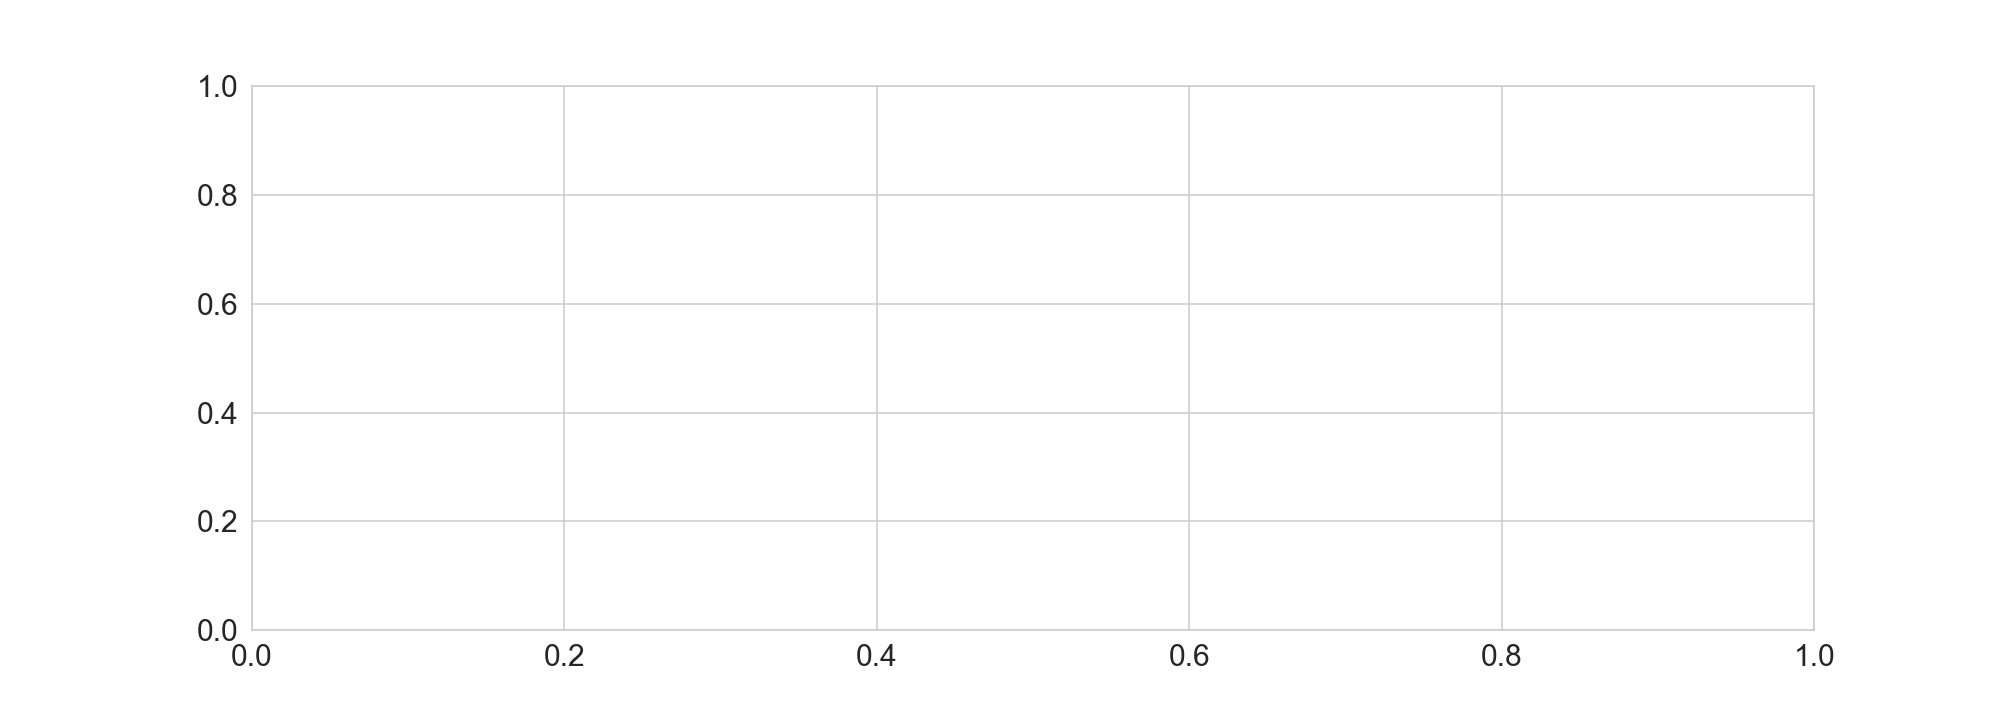

ValueError: a must be greater than 0 unless no samples are taken

In [193]:
examine_cluster(4, nk='k3')

#### Cluster 1

       fraction_weeks_active  fraction_active_period      ip_min      ip_max  \
count             194.000000                   194.0  194.000000  194.000000   
mean                0.070907                     0.0    0.913506    0.913506   
std                 0.040442                     0.0    0.050375    0.050375   
min                 0.012821                     0.0    0.800000    0.800000   
25%                 0.041667                     0.0    0.875000    0.875000   
50%                 0.058824                     0.0    0.923077    0.923077   
75%                 0.100000                     0.0    0.951786    0.951786   
max                 0.166667                     0.0    1.087719    1.087719   

          ip_mean  ip_std  when_activated  nq_min  nq_max  nq_mean  ...  \
count  194.000000   194.0           194.0   194.0   194.0    194.0  ...   
mean     0.913506     0.0             0.0     1.0     1.0      1.0  ...   
std      0.050375     0.0             0.0     0.0     

<IPython.core.display.Javascript object>


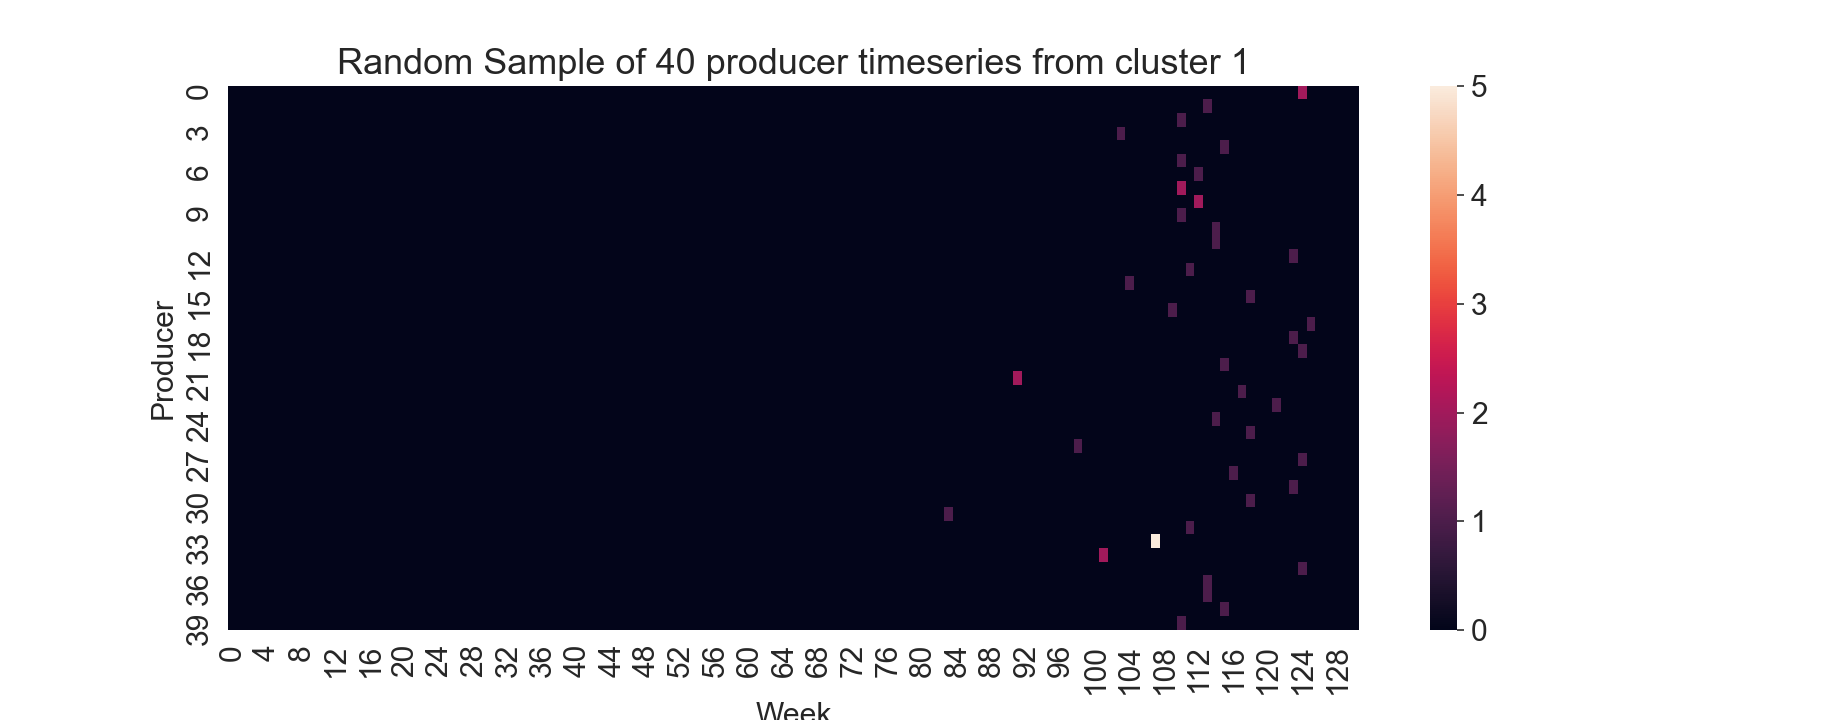

In [214]:
examine_cluster(1, nk='k4')

#### Cluster 2

       fraction_weeks_active  fraction_active_period      ip_min      ip_max  \
count             303.000000              303.000000  303.000000  303.000000   
mean                0.138400                0.282411    0.128885    0.694246   
std                 0.066627                0.157477    0.128231    0.147751   
min                 0.025641                0.020833    0.007634    0.428571   
25%                 0.086957                0.168440    0.032258    0.593750   
50%                 0.120000                0.266667    0.071429    0.666667   
75%                 0.176471                0.366667    0.200000    0.758418   
max                 0.333333                0.769231    0.470588    1.469231   

          ip_mean      ip_std  when_activated      nq_min      nq_max  \
count  303.000000  303.000000           303.0  303.000000  303.000000   
mean     0.333356    0.242808             0.0    0.311004    0.431787   
std      0.126325    0.100233             0.0    0.157091   

<IPython.core.display.Javascript object>


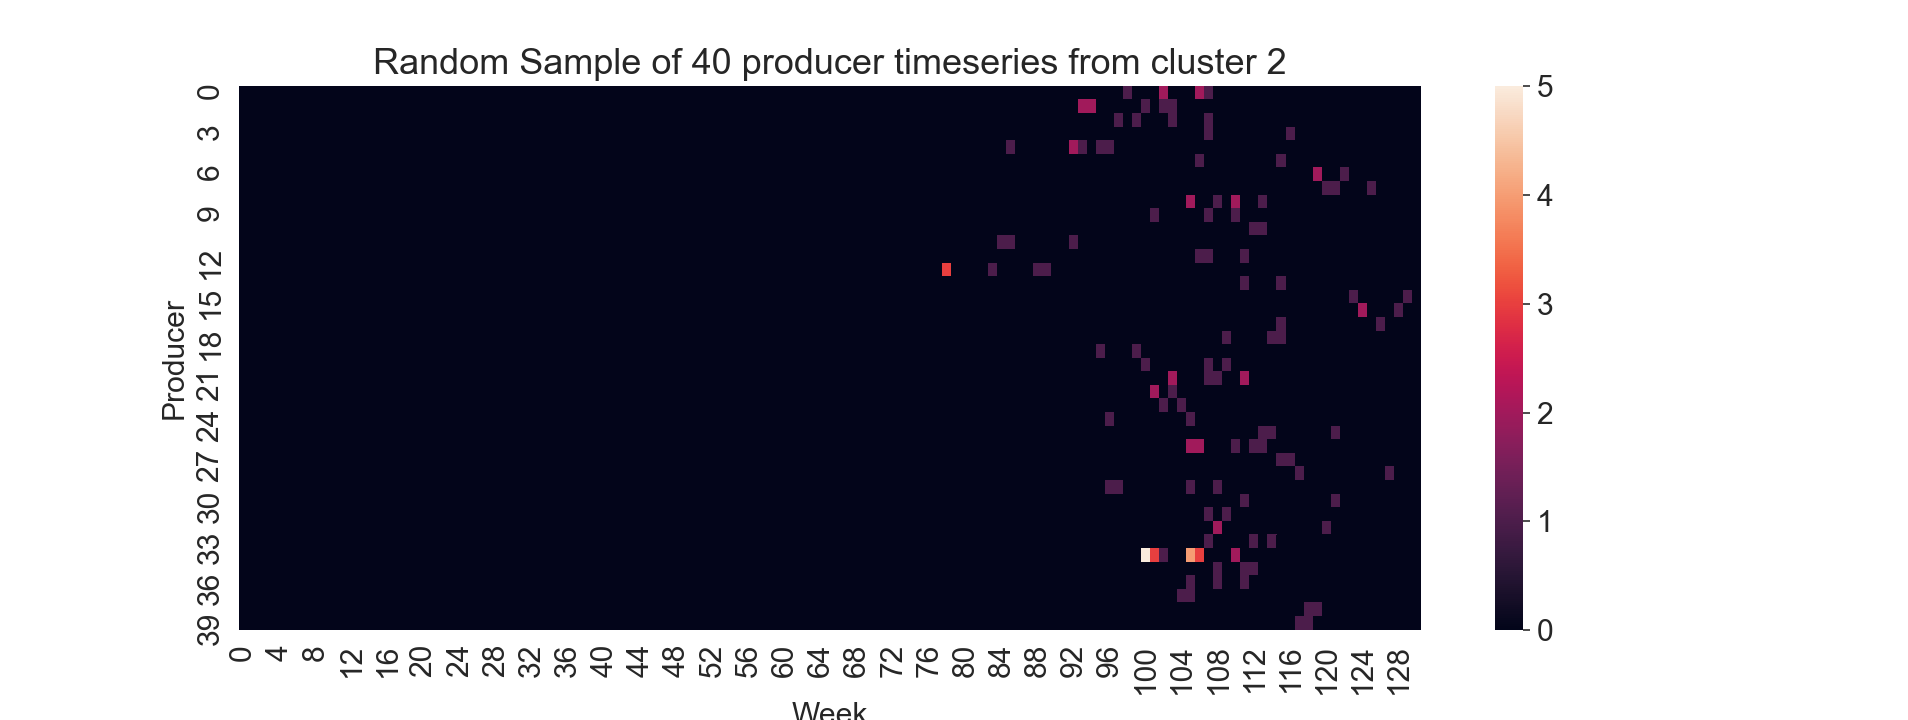

In [251]:
examine_cluster(2, nk='k4')

#### Cluster 0

       fraction_weeks_active  fraction_active_period     ip_min     ip_max  \
count              80.000000                    80.0  80.000000  80.000000   
mean                0.074798                     0.0   0.475184   0.475184   
std                 0.033847                     0.0   0.224474   0.224474   
min                 0.020408                     0.0   0.000000   0.000000   
25%                 0.045455                     0.0   0.325000   0.325000   
50%                 0.071429                     0.0   0.509259   0.509259   
75%                 0.100000                     0.0   0.666667   0.666667   
max                 0.166667                     0.0   0.793103   0.793103   

         ip_mean  ip_std  when_activated  nq_min  nq_max  nq_mean  ...  \
count  80.000000    80.0            80.0    80.0    80.0     80.0  ...   
mean    0.475184     0.0             0.0     1.0     1.0      1.0  ...   
std     0.224474     0.0             0.0     0.0     0.0      0.0  ...   
m

<IPython.core.display.Javascript object>


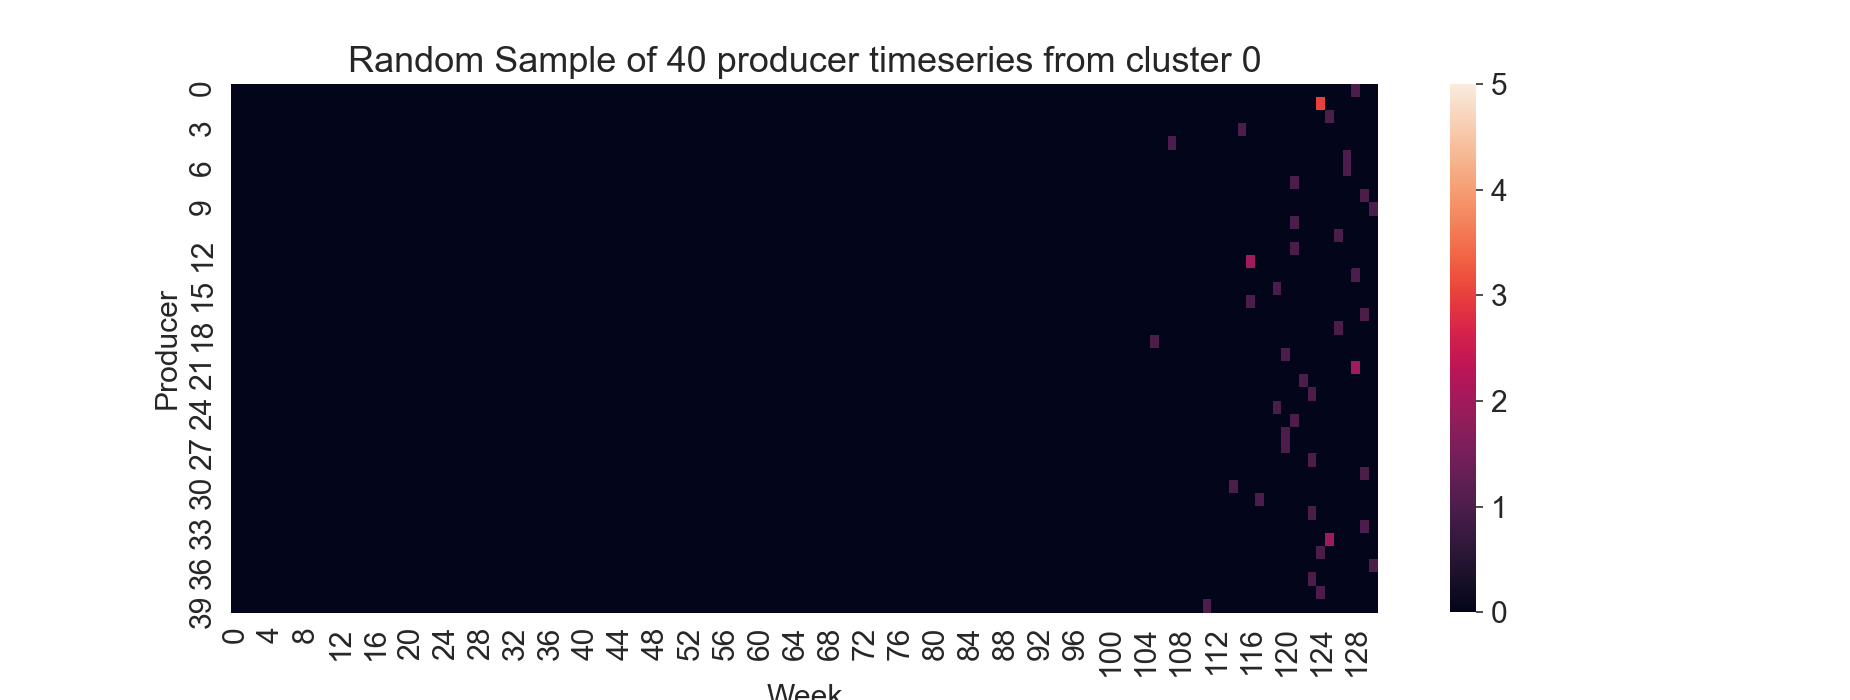

In [215]:
examine_cluster(0, nk='k4', vmax=5)

#### Cluster 3

       fraction_weeks_active  fraction_active_period      ip_min      ip_max  \
count             317.000000              317.000000  317.000000  317.000000   
mean                0.331708                0.554094    0.084236    0.418082   
std                 0.175704                0.201973    0.070916    0.127687   
min                 0.071429                0.047619    0.000000    0.083333   
25%                 0.210526                0.423077    0.045455    0.333333   
50%                 0.285714                0.555556    0.066667    0.428571   
75%                 0.411765                0.705882    0.105263    0.518519   
max                 1.000000                0.923077    0.470588    0.727273   

          ip_mean      ip_std  when_activated      nq_min      nq_max  \
count  317.000000  317.000000           317.0  317.000000  317.000000   
mean     0.204790    0.130981             0.0    0.197287    0.344455   
std      0.080638    0.060681             0.0    0.117120   

<IPython.core.display.Javascript object>


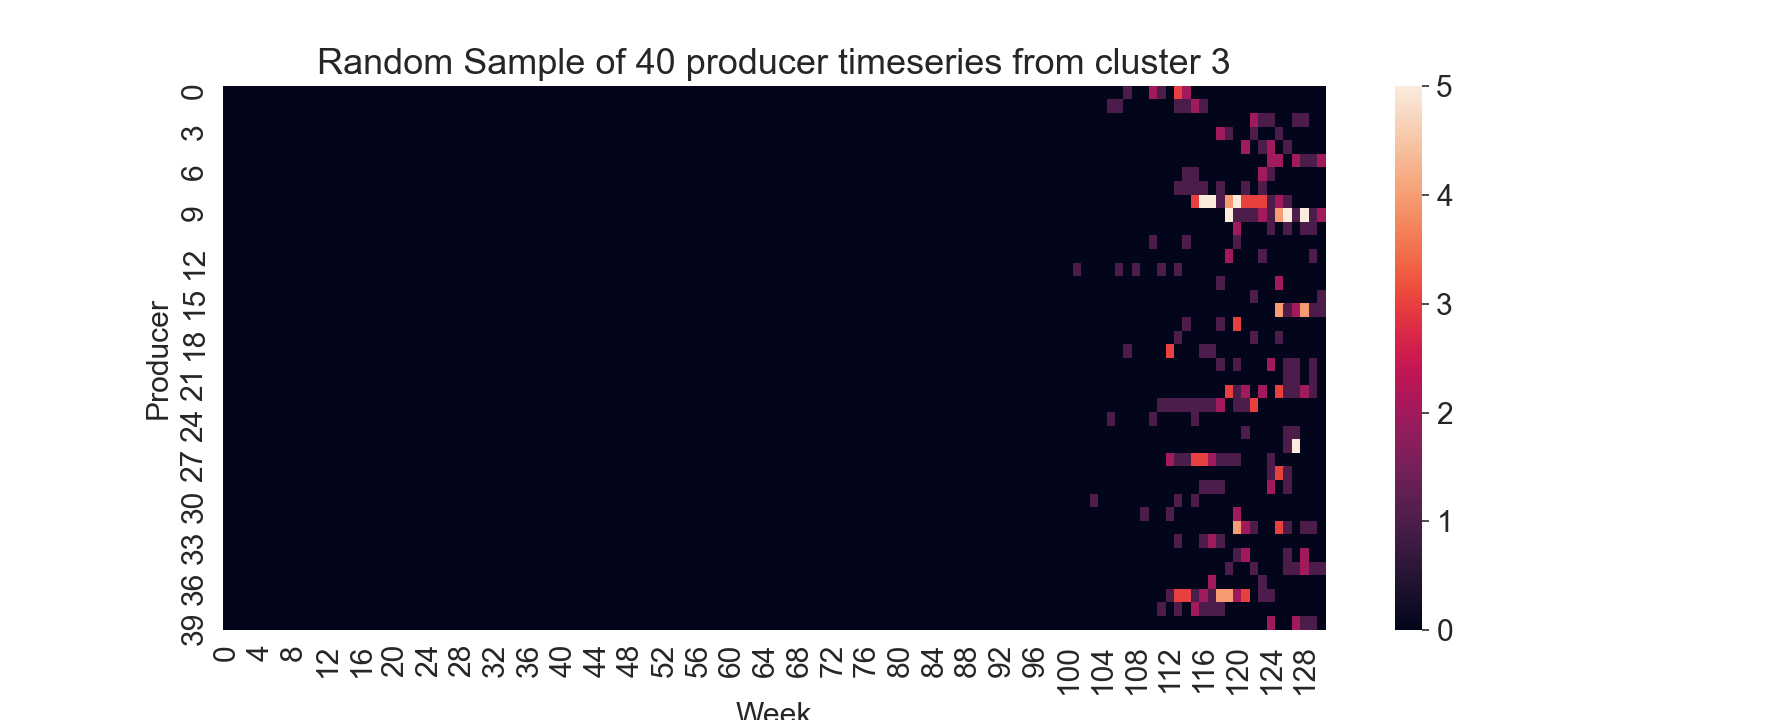

In [212]:
examine_cluster(3, nk='k4', vmax=5)

## Churn

### Extract inactivity intervals for clusters 1,2,4

### Get unscaled features

In [217]:
def ip_feature_extract(producer_code, ts):
    '''This will be applied to each row (timeseries of a single producer) of tsdf'''
    
    #Trim each producer time series to start at first week of quote or activation
    start_week = min(a_week[producer_code], q_week[producer_code])
    trimmed = ts.loc[start_week:]
    weeks_active_index = trimmed[trimmed>0].index
    nquotes = trimmed.sum()
    
    #get number of days between quotes and days from last quote until end
    inactive_periods = np.append([interval.days for interval in (weeks_active_index[1:] - weeks_active_index[:-1])],
                                 (trimmed.index[-1] - weeks_active_index[-1]).days)
    
#     #churn event if more than a week stop after last active
#     churn = False
#     if inactive_periods[-1]>=10:
#         churn = True
    
    features = {'producer_code': producer_code,
                'ip_days': inactive_periods, 
                'nquotes': nquotes
               }
    
    return features

In [218]:
ip_feature_list = []
for pc, ts in tsdf.iterrows():
    ip_feature_list.append(ip_feature_extract(pc,ts))

In [219]:
ipdf = pd.DataFrame(ip_feature_list)

In [233]:
ipdf.tail()

producer_code                                   ip_days  nquotes
889   WVSMACITYWD1                                   [133.0]      1.0
890     WWFMGA0001  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 14]     66.0
891  YOUNGSOK00001                     [35, 14, 21, 14, 119]      5.0
892      ZEIN00001                                  [28, 14]      3.0
893     ZOTIA00001                                  [56, 84]      3.0

Assemble data for seaborn

### Append to features df by year-part

In [253]:
pd.concat((yp_clusters[0][['producer_code','k5']],
           yp_clusters[1][['producer_code','k5']].rename(columns={'k5':'k5_2'})), axis=1).head(2)

producer_code  k5 producer_code  k5_2
0  ABRAHAM00001   2  ABRAHAM00001     0
1     ABRI00001   3     ABRI00001     2

In [195]:
transitions = pd.concat((yp_clusters[0][['producer_code','k5']],
           yp_clusters[1][['producer_code','k5']].rename(columns={'k5':'k5_2'})), axis=1)\
[['k5','k5_2']].value_counts().reset_index()

In [203]:
transitions.rename(columns={0:'count'}, inplace=True)

In [198]:
fh_levels = {3:1,4:2,1:3,0:4,2:5}
sh_levels = {2:1,4:2,1:3,3:4,0:5}

In [201]:
transitions['first_half'] = transitions.k5.map(lambda x: fh_levels[x])
transitions['second_half'] = transitions.k5_2.map(lambda x: sh_levels[x])

In [211]:
transitions['frac'] = transitions['count']/340

In [217]:
transitions.iloc[:,2:]

count  first_half  second_half      frac
0      90           5            5  0.264706
1      79           4            4  0.232353
2      30           4            5  0.088235
3      23           3            4  0.067647
4      22           3            3  0.064706
5      18           5            4  0.052941
6      17           4            3  0.050000
7      13           3            2  0.038235
8      12           3            1  0.035294
9      10           1            1  0.029412
10      7           4            2  0.020588
11      5           1            3  0.014706
12      3           5            3  0.008824
13      3           4            1  0.008824
14      2           5            2  0.005882
15      1           2            3  0.002941
16      1           1            2  0.002941
17      1           3            5  0.002941
18      1           1            4  0.002941
19      1           2            4  0.002941
20      1           2            2  0.002941

In [215]:
transitions[transitions.second_half - transitions.first_half<0].iloc[:,2:]

count  first_half  second_half      frac
5      18           5            4  0.052941
6      17           4            3  0.050000
7      13           3            2  0.038235
8      12           3            1  0.035294
10      7           4            2  0.020588
12      3           5            3  0.008824
13      3           4            1  0.008824
14      2           5            2  0.005882

In [208]:
(transitions[transitions.second_half - transitions.first_half<0]['count']/340).sum()

0.22058823529411764

In [169]:
yp_clusters[0].merge(ipdf, how='left', on='producer_code').\
groupby('k5').agg({'nquotes':['mean','std']}).sort_values(('nquotes','mean'))

nquotes            
          mean         std
k5                        
3     2.176471    1.424574
4     3.333333    3.214550
1     8.478873    5.653972
0    23.507353   22.821691
2   146.265487  381.175040

In [172]:
yp_clusters[1].merge(ipdf, how='left', on='producer_code').\
groupby('k5').agg({'nquotes':['mean','std']}).sort_values(('nquotes','mean'))

nquotes            
          mean         std
k5                        
2     3.920000    3.762978
4     8.791667    9.614207
1    14.583333   35.661430
3    22.450820   16.962819
0   137.404959  369.548544

In [171]:
yp_clusters[0].merge(ipdf, how='left', on='producer_code').\
explode('ip_days').astype({'ip_days':'int'}).\
groupby('k5').agg({'ip_days':['mean','std']}).sort_values(('ip_days','mean'))

ip_days            
          mean         std
k5                        
2     9.588948    9.277341
0    22.060018   24.053944
4    30.800000   27.844010
1    50.841336   61.492183
3   163.058824  131.507101

In [173]:
yp_clusters[1].merge(ipdf, how='left', on='producer_code').\
explode('ip_days').astype({'ip_days':'int'}).\
groupby('k5').agg({'ip_days':['mean','std']}).sort_values(('ip_days','mean'))

ip_days            
          mean         std
k5                        
0     9.667581    6.650853
3    22.739623   23.037201
1    44.916667   50.094326
4    56.048611   65.464594
2   111.556962  131.877444

### Append to features df

In [221]:
all_features = fdf.merge(ipdf, how='left', on='producer_code')

In [293]:
all_features.head(2)

producer_code  fraction_weeks_active  fraction_active_period    ip_min  \
0   3BRINS00001               0.100000                0.000000  0.900000   
1   618INC00001               0.157895                0.315789  0.105263   

     ip_max   ip_mean    ip_std  when_activated    nq_min    nq_max  ...  \
0  0.900000  0.900000  0.000000             0.0  1.000000  1.000000  ...   
1  0.631579  0.315789  0.227394             0.0  0.333333  0.333333  ...   

   q3_quotes  q4_quotes  q5_quotes  k4  k5     tsne1      tsne2  k3  \
0        0.0        0.0        0.0   1   2  7.236337 -50.780754   0   
1        0.0        0.0        0.0   2   1  7.840956  28.072641   1   

        ip_days  nquotes  
0        [63.0]      1.0  
1  [28, 14, 84]      3.0  

[2 rows x 24 columns]

In [291]:
all_features.groupby('k4').agg({'nquotes':['mean','std']}).columns

MultiIndex([('nquotes', 'mean'),
            ('nquotes',  'std')],
           )

In [223]:
all_features.explode('ip_days').astype({'ip_days':'int'}).groupby('k4').agg({'ip_days':['mean','std']})

ip_days            
          mean         std
k4                        
0    61.425000   49.018667
1   126.396907   81.814096
2    56.653846  107.056857
3    20.346900   21.773121

### Get probability curves based on inactivity period only

In [886]:
label_dict = dict(zip(list(range(5)),
                      ('active','very_low','low','very_active','immediate_churn')))

df_list = []
for k in range(5):
    ip_series = ipdf[ipdf.producer_code.isin(fdf[fdf.k5==k].producer_code.values)].\
    ip_days.explode().value_counts()
    ip_series = ip_series / ip_series.sum()
    
    df = ip_series.reset_index().rename(columns={'index':'ip_length','ip_days':'count'})
    df['running_total'] = df.sort_values('ip_length')['count'].cumsum()
    df['probability_member'] = 1 - df['running_total']
    df['cluster'] = '-'.join([label_dict[k],str(k)])
    df_list.append(df)
    
final = pd.concat(df_list)

In [887]:
final.sort_values(['cluster','ip_length'])

ip_length     count  running_total  probability_member     cluster
8         0.0  0.020951       0.020951        9.790493e-01    active-0
0         7.0  0.344897       0.365848        6.341518e-01    active-0
1        14.0  0.202298       0.568146        4.318540e-01    active-0
2        21.0  0.126830       0.694976        3.050237e-01    active-0
3        28.0  0.082676       0.777653        2.223474e-01    active-0
..        ...       ...            ...                 ...         ...
35      294.0  0.003472       0.986111        1.388889e-02  very_low-1
39      301.0  0.003472       0.989583        1.041667e-02  very_low-1
40      315.0  0.003472       0.993056        6.944444e-03  very_low-1
42      322.0  0.003472       0.996528        3.472222e-03  very_low-1
33      336.0  0.003472       1.000000        5.551115e-16  very_low-1

[148 rows x 5 columns]

<IPython.core.display.Javascript object>


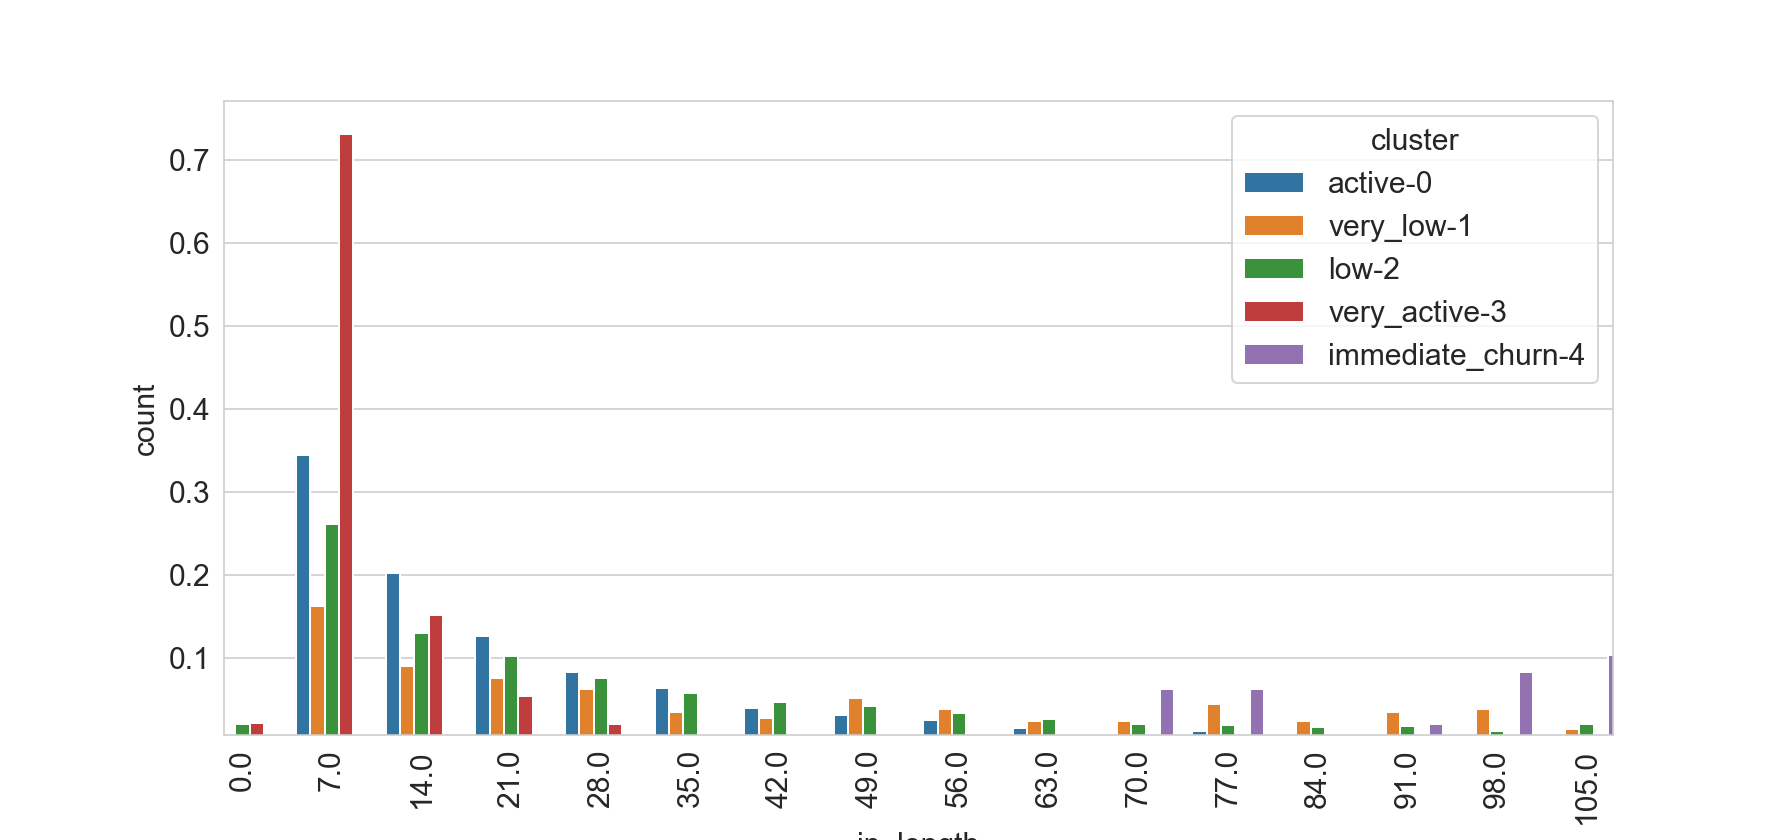

In [889]:
_, ax = plt.subplots()

sns.barplot(x="ip_length", y="count", hue="cluster", data=final, ax=ax)

ax.xaxis.set_tick_params(rotation=90);

<IPython.core.display.Javascript object>


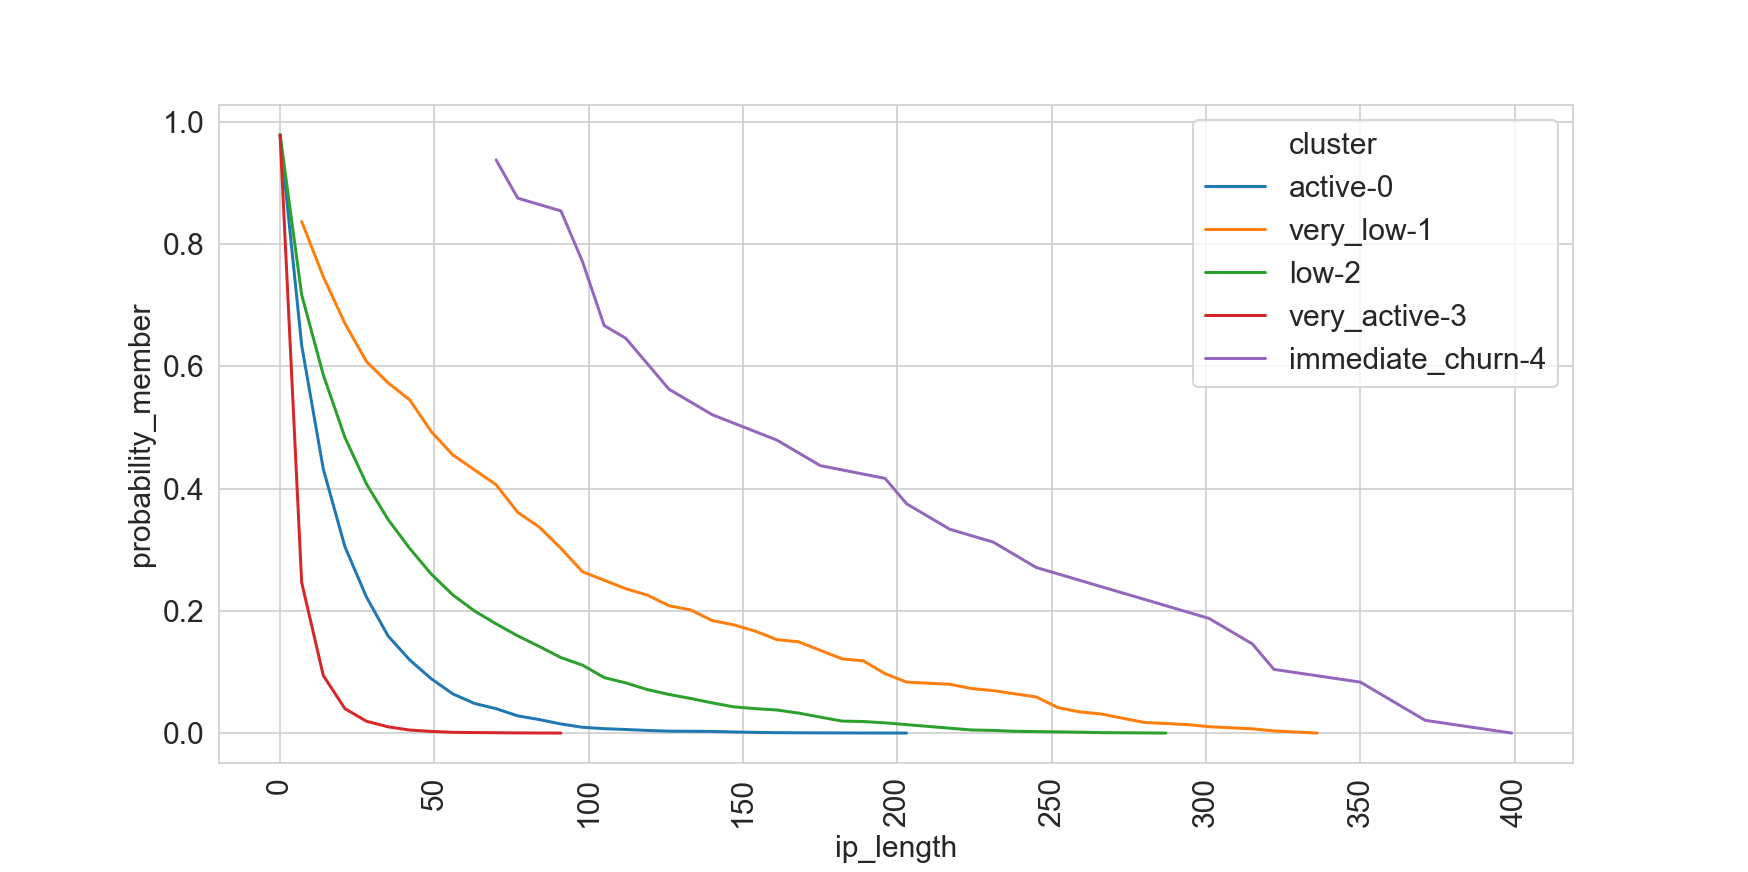

In [890]:
_, ax = plt.subplots()

sns.lineplot(x="ip_length", y="probability_member", hue="cluster", data=final, ax=ax)

ax.xaxis.set_tick_params(rotation=90);